# Crop Yield Prediction using Weather Data and NDVI Time Series

## Project Overview
This notebook implements a machine learning pipeline to predict crop yields using:
- **Satellite imagery** (Sentinel-2) for vegetation health monitoring via NDVI (Normalized Difference Vegetation Index)
- **Weather data** (ERA5 temperature, CHIRPS precipitation) for climatic conditions
- **Random Forest** regression model for yield prediction

## Objective
Predict the crop yield for the current growing season (Jan-Jun 2025) based on historical data from 4 previous seasons and current satellite + weather observations.

## Methodology
1. Extract NDVI time series from Sentinel-2 imagery
2. Extract weather variables (temperature, precipitation, humidity, wind)
3. Engineer features from time series data
4. Train Random Forest model with cross-validation
5. Generate predictions with confidence intervals

## Study Area
Small agricultural plot in Uganda (~0.18 hectares)
- Latitude: 1.117°N
- Longitude: 33.903°E

In [7]:
!pip install -q earthengine-api geemap



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## Step 1: Environment Setup

### Install Required Libraries
We need two main packages:
- **earthengine-api**: Python client for Google Earth Engine (satellite imagery platform)
- **geemap**: Interactive mapping library for Earth Engine data visualization

These libraries enable us to access and process satellite imagery and weather data from Google's cloud platform.

In [8]:
import ee
import geemap
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Libraries
- **ee**: Google Earth Engine API for satellite data access
- **geemap**: Interactive mapping and visualization
- **datetime**: Date and time manipulation for time series
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computing and array operations
- **matplotlib.pyplot**: Data visualization and plotting

In [9]:
ee.Authenticate()
ee.Initialize(project='dojohub-satellite-imagery')



### Authenticate and Initialize Earth Engine
This cell connects to Google Earth Engine servers. You'll need to:
1. Run `ee.Authenticate()` - Opens browser for Google account login
2. Run `ee.Initialize()` - Connects to your Earth Engine project

**Note**: Replace `'dojohub-satellite-imagery'` with your own Earth Engine project ID.

## Step 2: Define Study Area

### Area of Interest (AOI)
We define a small agricultural plot boundary using a polygon with 5 coordinate pairs (longitude, latitude).

**Location**: Uganda, East Africa
- The polygon covers approximately 0.18 hectares
- Coordinates are in decimal degrees (WGS84)

This is the specific field where we'll monitor vegetation health and predict crop yields.

In [10]:
region = ee.Geometry.Polygon(
    [[
        [33.903583, 1.117219],
        [33.89897,  1.117112],
        [33.898787, 1.115696],
        [33.900161, 1.115761],
        [33.903583, 1.117219]
    ]]
)

print("AOI defined – area ≈", round(region.area().getInfo() / 10000, 2), "ha")

AOI defined – area ≈ 5.13 ha


## Step 3: Cloud Masking Function

### Why Cloud Masking?
Clouds in satellite images can interfere with NDVI calculations. This function removes cloudy pixels using Sentinel-2's quality band (QA60).

**How it works:**
- Uses bit masking to identify cloud and cirrus cloud pixels
- Removes these pixels from the image
- Converts digital numbers to reflectance values (0-1 range)

This ensures we only use clear, high-quality satellite observations.

In [11]:
def mask_clouds(image):
    """Basic cloud & cirrus mask using QA60 band"""
    qa = image.select('QA60')
    cloud_bit_mask  = 1 << 10
    cirrus_bit_mask = 1 << 11

    mask = (
        qa.bitwiseAnd(cloud_bit_mask).eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000)

## Step 4: Define Growing Seasons

### Historical and Current Seasons
We define 5 growing seasons:
- **4 historical seasons** (2024) with known crop yields (kg)
- **1 current season** (Jan-Jun 2025) - yield to be predicted

Each season includes:
- **name**: Identifier for the growing period
- **plant**: Planting start date
- **harvest**: Expected harvest date
- **actual_yield**: Recorded yield in kilograms (None for current season)

This data forms the foundation for training our prediction model.

In [12]:
harvest_cycles = [
    {'name': 'Feb-Jun 2024',     'plant': '2024-02-01', 'harvest': '2024-06-01', 'actual_yield': 2000},
    {'name': 'Jul-Dec 2024',     'plant': '2024-07-01', 'harvest': '2024-12-01', 'actual_yield': 2000},
    {'name': 'Jan-Jun 2024 (late)','plant': '2024-01-15', 'harvest': '2024-06-15', 'actual_yield': 1000},
    {'name': 'Jun-Nov 2024',     'plant': '2024-06-01', 'harvest': '2024-11-01', 'actual_yield': 1500},
    {'name': 'Jan-Jun 2025 (current)', 'plant': '2025-01-01', 'harvest': '2025-06-01', 'actual_yield': None},
]

print(f"Defined {len(harvest_cycles)} growing seasons (last one = current)")

Defined 5 growing seasons (last one = current)


## Step 5: NDVI Time Series Extraction

### What is NDVI?
**Normalized Difference Vegetation Index (NDVI)** measures vegetation health:
- Calculated from Red and Near-Infrared bands: `(NIR - Red) / (NIR + Red)`
- Values range from -1 to +1 (higher = healthier vegetation)
- Green, healthy crops have NDVI > 0.3

### This Function:
1. Divides the growing season into 10-day intervals
2. For each interval, searches for cloud-free Sentinel-2 images
3. Calculates mean and standard deviation of NDVI for the field
4. Returns a time series of vegetation health throughout the season

This creates a "vegetation health profile" for each growing season.

In [13]:
def extract_ndvi_timeseries(start_date, end_date, polygon, interval_days=10):
    """
    Extract mean & std NDVI every ~10 days during a growing season.
    Uses 5-day image windows to increase chance of cloud-free data.

    Returns: list of dicts later converted to DataFrame
    """
    start = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end   = datetime.datetime.strptime(end_date,   '%Y-%m-%d')
    current = start
    ndvi_data = []

    while current <= end:
        date_str = current.strftime('%Y-%m-%d')
        next_date = (current + datetime.timedelta(days=5)).strftime('%Y-%m-%d')

        coll = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(polygon)
            .filterDate(date_str, next_date)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
            .map(mask_clouds)
        )

        count = coll.size().getInfo()

        if count > 0:
            img = coll.median()
            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')

            stats = ndvi.reduceRegion(
                reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
                geometry=polygon,
                scale=10,
                bestEffort=True
            ).getInfo()

            mean_val = stats.get('NDVI_mean')
            std_val  = stats.get('NDVI_stdDev') or 0.0

            if mean_val is not None:
                ndvi_data.append({
                    'date': date_str,
                    'ndvi_mean': round(mean_val, 4),
                    'ndvi_std':  round(std_val,  4),
                    'image_count': count
                })
                print(f"{date_str}: NDVI = {mean_val:.3f} (±{std_val:.3f})  [{count} img]")
            else:
                print(f"{date_str}: NDVI calculation failed (all masked)")
        else:
            print(f"{date_str}: No suitable images")

        current += datetime.timedelta(days=interval_days)

    return ndvi_data

## Step 6: Extract NDVI for All Seasons

### Data Collection Process
This cell applies the NDVI extraction function to all 5 growing seasons defined earlier.

**Process:**
1. Loop through each season (Feb-Jun 2024, Jul-Dec 2024, etc.)
2. Extract NDVI values every 10 days during that period
3. Attach metadata (season name, actual yield) to each data point
4. Combine all seasons into a single DataFrame

**Expected Output:**
- ~46 NDVI observations across all 5 seasons
- Each observation includes: date, NDVI mean, NDVI std, season name, yield

In [14]:
all_timeseries = []

for cycle in harvest_cycles:
    print(f"\n{'═'*65}")
    print(f"Processing: {cycle['name']}  ({cycle['plant']} → {cycle['harvest']})")
    print(f"{'═'*65}")

    ts = extract_ndvi_timeseries(
        cycle['plant'],
        cycle['harvest'],
        region,
        interval_days=10
    )

    # Enrich with metadata
    for point in ts:
        point['cycle_name']   = cycle['name']
        point['actual_yield'] = cycle['actual_yield']

    all_timeseries.extend(ts)

df_timeseries = pd.DataFrame(all_timeseries)
df_timeseries['date'] = pd.to_datetime(df_timeseries['date'])

print(f"\nCollected {len(df_timeseries)} NDVI points across {df_timeseries['cycle_name'].nunique()} seasons")
display(df_timeseries.head(8))


═════════════════════════════════════════════════════════════════
Processing: Feb-Jun 2024  (2024-02-01 → 2024-06-01)
═════════════════════════════════════════════════════════════════
2024-02-01: No suitable images
2024-02-11: NDVI = 0.643 (±0.096)  [1 img]
2024-02-21: No suitable images
2024-03-02: NDVI = 0.591 (±0.123)  [3 img]
2024-03-12: NDVI = 0.492 (±0.165)  [4 img]
2024-03-22: NDVI = 0.471 (±0.180)  [2 img]
2024-04-01: NDVI calculation failed (all masked)
2024-04-11: No suitable images
2024-04-21: NDVI = 0.708 (±0.175)  [2 img]
2024-05-01: No suitable images
2024-05-11: NDVI = 0.748 (±0.101)  [2 img]
2024-05-21: NDVI calculation failed (all masked)
2024-05-31: NDVI = 0.764 (±0.076)  [1 img]

═════════════════════════════════════════════════════════════════
Processing: Jul-Dec 2024  (2024-07-01 → 2024-12-01)
═════════════════════════════════════════════════════════════════
2024-07-01: NDVI = 0.646 (±0.128)  [4 img]
2024-07-11: No suitable images
2024-07-21: No suitable images
20

,date,ndvi_mean,ndvi_std,image_count,cycle_name,actual_yield
0,2024-02-11,0.6433,0.0961,1,Feb-Jun 2024,2000.0
1,2024-03-02,0.5912,0.1229,3,Feb-Jun 2024,2000.0
2,2024-03-12,0.4921,0.1649,4,Feb-Jun 2024,2000.0
3,2024-03-22,0.4713,0.1796,2,Feb-Jun 2024,2000.0
4,2024-04-21,0.7076,0.1752,2,Feb-Jun 2024,2000.0
5,2024-05-11,0.7480,0.1005,2,Feb-Jun 2024,2000.0
6,2024-05-31,0.7636,0.0762,1,Feb-Jun 2024,2000.0
7,2024-07-01,0.6465,0.1278,4,Jul-Dec 2024,2000.0


## Step 7: Visualize Current NDVI

### Interactive Map
This section creates an interactive map showing the current vegetation health (January 2025).

**Map Layers:**
- **Red boundary**: The agricultural plot
- **Color gradient**: NDVI values
  - Dark red (0.3): Low vegetation / bare soil
  - Green (0.6-0.7): Healthy crops
  - Dark green (0.9): Very healthy, dense vegetation

This provides a visual check of current crop conditions.

In [15]:
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(region)
    .filterDate('2025-01-01', '2025-01-26')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .map(mask_clouds)
)

print("Images available Jan 2025:", collection.size().getInfo())

if collection.size().getInfo() > 0:
    image = collection.median().clip(region)
    ndvi  = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    ndvi_vis = {
        'min': 0.3, 'max': 0.9,
        'palette': ['darkred', 'orange', 'yellow', 'lime', 'green', 'darkgreen']
    }

    Map = geemap.Map()
    Map.centerObject(region, 19)
    Map.addLayer(region, {'color': 'red', 'width': 4}, 'Plot Boundary')
    Map.addLayer(ndvi, ndvi_vis, 'NDVI Jan 2025', opacity=0.95)
    Map.add_legend(title='NDVI', vis_params=ndvi_vis,
                   labels=['Low 0.3', 'Moderate', 'Good', 'Very Good', 'Excellent 0.9'])
    display(Map)
else:
    print("No cloud-free images in Jan 2025 period")

Images available Jan 2025: 12


Map(center=[1.1165789652066664, 33.9005319163271], controls=(WidgetControl(options=['position', 'transparent_b…

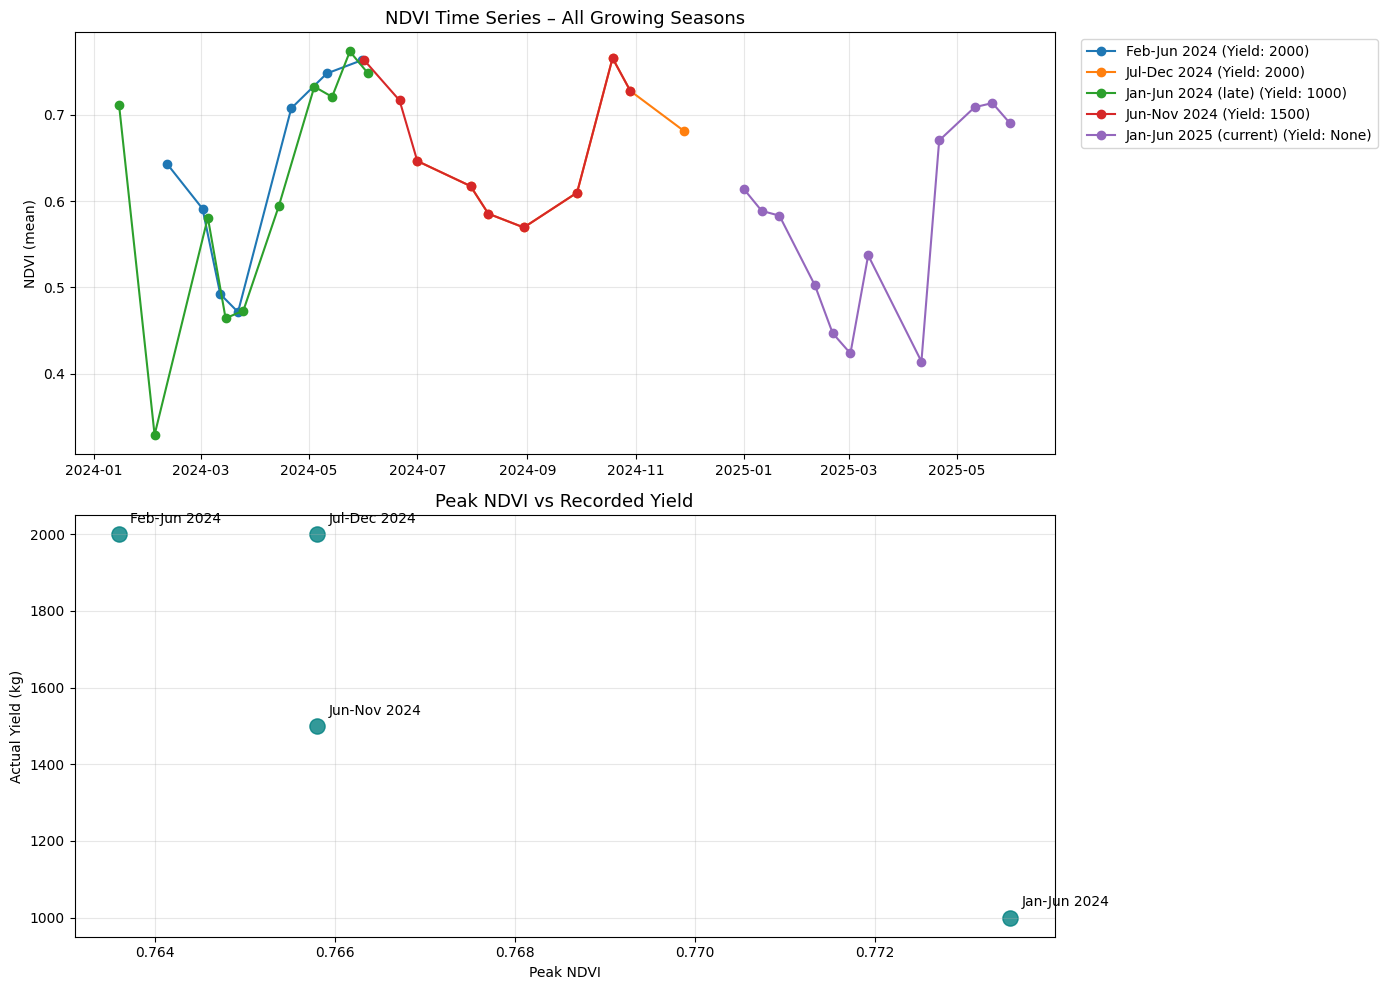

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

for cycle in harvest_cycles:
    data = df_timeseries[df_timeseries['cycle_name'] == cycle['name']]
    if len(data) > 0:
        axes[0].plot(
            data['date'], data['ndvi_mean'],
            marker='o', linewidth=1.5,
            label=f"{cycle['name']} (Yield: {cycle['actual_yield']})"
        )

axes[0].set_title('NDVI Time Series – All Growing Seasons', fontsize=13)
axes[0].set_ylabel('NDVI (mean)')
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

peak_ndvi = df_timeseries.groupby('cycle_name')['ndvi_mean'].max()
yields    = df_timeseries.groupby('cycle_name')['actual_yield'].first()
valid     = yields.dropna()

axes[1].scatter(peak_ndvi[valid.index], valid, s=120, alpha=0.8, c='teal')
for name in valid.index:
    x, y = peak_ndvi[name], valid[name]
    axes[1].annotate(name[:12], (x, y), xytext=(8,8), textcoords='offset points')

axes[1].set_xlabel('Peak NDVI')
axes[1].set_ylabel('Actual Yield (kg)')
axes[1].set_title('Peak NDVI vs Recorded Yield', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### NDVI Time Series Plots
Two comparative visualizations:

**Plot 1: NDVI Trajectories**
- Shows how vegetation health changes over time for each season
- Each line represents one growing season
- Allows comparison of vegetation patterns between high-yield and low-yield seasons

**Plot 2: Peak NDVI vs Yield**
- Scatter plot showing relationship between maximum NDVI and final yield
- Helps identify if peak vegetation health correlates with crop productivity

## Step 8: Feature Engineering (NDVI Only)

### Converting Time Series to Features
This function summarizes the NDVI time series into statistical features for machine learning:

**NDVI-derived Features:**
1. **peak_ndvi**: Maximum vegetation health reached
2. **mean_ndvi**: Average vegetation health throughout season
3. **min_ndvi**: Lowest vegetation health (crop stress indicator)
4. **ndvi_range**: Variation in vegetation health
5. **auc_ndvi**: Area under the NDVI curve (cumulative growth)
6. **peak_timing**: When maximum health occurred (0=start, 1=end)
7. **max_growth_rate**: Fastest vegetation growth period
8. **n_observations**: Data quality indicator (number of clear images)

These features capture the "shape" and "magnitude" of crop growth patterns.

In [17]:
def extract_features(df, cycle_name):
    sub = df[df['cycle_name'] == cycle_name].copy()
    if len(sub) == 0:
        return None

    sub = sub.sort_values('date')
    ndvi_vals = sub['ndvi_mean'].values

    return {
        'cycle_name': cycle_name,
        'peak_ndvi':    np.max(ndvi_vals),
        'mean_ndvi':    np.mean(ndvi_vals),
        'min_ndvi':     np.min(ndvi_vals),
        'ndvi_range':   np.ptp(ndvi_vals),
        'auc_ndvi':     np.trapezoid(ndvi_vals),
        'peak_timing':  np.argmax(ndvi_vals) / len(ndvi_vals),
        'max_growth_rate': np.max(np.diff(ndvi_vals)) if len(ndvi_vals)>1 else 0,
        'n_observations': len(ndvi_vals),
        'actual_yield': sub['actual_yield'].iloc[0]
    }

features_list = [extract_features(df_timeseries, c['name']) for c in harvest_cycles]
features_list = [f for f in features_list if f is not None and f['actual_yield'] is not None]

df_features = pd.DataFrame(features_list)
print("\nExtracted features for yield modeling:")
display(df_features.round(3))


Extracted features for yield modeling:


,cycle_name,peak_ndvi,mean_ndvi,min_ndvi,ndvi_range,auc_ndvi,peak_timing,max_growth_rate,n_observations,actual_yield
0,Feb-Jun 2024,0.764,0.631,0.471,0.292,3.714,0.857,0.236,7,2000.0
1,Jul-Dec 2024,0.766,0.650,0.569,0.196,4.540,0.625,0.156,8,2000.0
2,Jan-Jun 2024 (late),0.774,0.613,0.329,0.445,5.398,0.800,0.252,10,1000.0
3,Jun-Nov 2024,0.766,0.667,0.569,0.196,5.257,0.778,0.156,9,1500.0
4,Jan-Jun 2025 (current),0.714,0.574,0.414,0.300,6.240,0.833,0.256,12,NaN


## Step 9: Weather Data Integration

### Why Add Weather Data?
While NDVI shows crop health, weather explains WHY crops are healthy or stressed:
- **Temperature**: Affects growth rate and stress
- **Precipitation**: Water availability for crops
- **Humidity**: Disease risk and evapotranspiration
- **Wind**: Mechanical damage and pollination

### Data Sources:
- **ERA5 Land**: European reanalysis climate data (temperature, humidity, wind, pressure)
- **CHIRPS**: Climate Hazards Group rainfall estimates (highly accurate for Africa)

Weather data is extracted for the same dates as NDVI measurements to ensure synchronization.

### Test Weather Data Availability
Before processing all dates, we test if weather datasets are accessible for our location.

**Testing:**
1. **ERA5**: Temperature, humidity, wind, pressure (11km resolution)
2. **CHIRPS**: Daily precipitation (5.5km resolution)
3. **MODIS**: Backup temperature source (1km resolution)

This diagnostic helps identify any data access issues before full extraction.

In [18]:
print("Testing weather data sources for your location...")
print("="*70)

test_date = '2024-03-01'

try:
    era5_test = (
        ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        .filterBounds(region)
        .filterDate('2024-03-01', '2024-03-05')
        .first()
    )
    
    era5_bands = era5_test.bandNames().getInfo()
    print(f"ERA5 Daily Aggregate: {len(era5_bands)} bands available")
    print(f"  Available bands: {', '.join(era5_bands[:5])}...")
    
    test_stats = era5_test.select('temperature_2m').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000
    ).getInfo()
    
    if test_stats.get('temperature_2m') is not None:
        temp = test_stats.get('temperature_2m') - 273.15
        print(f"  Sample temperature: {temp:.1f}°C")
    else:
        print(f"  WARNING: ERA5 returns None for your location")
except Exception as e:
    print(f"ERA5 Daily Aggregate failed: {str(e)}")

try:
    chirps_test = (
        ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
        .filterBounds(region)
        .filterDate('2024-03-01', '2024-03-05')
        .first()
    )
    
    chirps_stats = chirps_test.select('precipitation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    ).getInfo()
    
    precip = chirps_stats.get('precipitation')
    if precip is not None:
        print(f"CHIRPS Rainfall: {precip:.1f}mm")
    else:
        print(f"CHIRPS returns None for your location")
except Exception as e:
    print(f"CHIRPS failed: {str(e)}")

try:
    modis_test = (
        ee.ImageCollection('MODIS/061/MOD11A1')
        .filterBounds(region)
        .filterDate('2024-03-01', '2024-03-05')
        .first()
    )
    
    modis_stats = modis_test.select('LST_Day_1km').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=1000
    ).getInfo()
    
    lst = modis_stats.get('LST_Day_1km')
    if lst:
        temp_c = (lst * 0.02) - 273.15
        print(f"MODIS Temperature: {temp_c:.1f}°C (alternative source)")
    else:
        print(f"MODIS returns None")
except Exception as e:
    print(f"MODIS failed: {str(e)}")

print("\n" + "="*70)

Testing weather data sources for your location...
ERA5 Daily Aggregate: 150 bands available
  Available bands: dewpoint_temperature_2m, temperature_2m, skin_temperature, soil_temperature_level_1, soil_temperature_level_2...
CHIRPS returns None for your location
MODIS returns None



## Diagnose & Fix Weather Data Issues
Investigate why ERA5/CHIRPS return None and implement alternative approach

In [19]:
print("Diagnosing weather data issue...")
print("="*70)
print(f"Your location: {region.coordinates().getInfo()}")
print(f"Centroid: {region.centroid().coordinates().getInfo()}")

center_point = region.centroid()

print("\nTesting with center point geometry instead of polygon...")
print("-"*70)

try:
    era5_point = (
        ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        .filterBounds(center_point)
        .filterDate('2024-03-01', '2024-03-02')
        .first()
    )
    
    era5_point_stats = era5_point.select('temperature_2m').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=center_point,
        scale=11000,
        bestEffort=True
    ).getInfo()
    
    temp_k = era5_point_stats.get('temperature_2m')
    if temp_k:
        temp_c = temp_k - 273.15
        print(f"ERA5 (point, 11km scale): {temp_c:.1f}°C")
    else:
        print(f"ERA5 still returns None with point geometry")
except Exception as e:
    print(f"ERA5 point test failed: {str(e)}")

try:
    chirps_point = (
        ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
        .filterBounds(center_point)
        .filterDate('2024-03-01', '2024-03-02')
        .first()
    )
    
    chirps_point_stats = chirps_point.select('precipitation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=center_point,
        scale=5566,
        bestEffort=True
    ).getInfo()
    
    precip = chirps_point_stats.get('precipitation')
    if precip is not None:
        print(f"CHIRPS (point, 5.5km scale): {precip:.1f}mm")
    else:
        print(f"CHIRPS still returns None with point geometry")
except Exception as e:
    print(f"CHIRPS point test failed: {str(e)}")

print("\nTesting alternative: NASA POWER (Agricultural Weather)")
print("-"*70)
try:
    coords = center_point.coordinates().getInfo()
    lon, lat = coords[0], coords[1]
    
    power_point = ee.Geometry.Point([lon, lat])
    
    print(f"Location: {lat:.4f}°N, {lon:.4f}°E")
    print("NASA POWER not directly available in Earth Engine")
    print("   Recommendation: Use ERA5 with point geometry + larger scale")
    
except Exception as e:
    print(f"Info: {str(e)}")

print("\n" + "="*70)
print("SOLUTION:")
print("  1. Use center_point geometry instead of polygon")
print("  2. Use coarser scale: ERA5=11000m, CHIRPS=5566m")
print("  3. If still None, there may be a date/coverage issue")

Diagnosing weather data issue...
Your location: [[[33.903583, 1.117219], [33.89897, 1.117112], [33.898787, 1.115696], [33.900161, 1.115761], [33.903583, 1.117219]]]
Centroid: [33.9005319163271, 1.1165789652066664]

Testing with center point geometry instead of polygon...
----------------------------------------------------------------------
ERA5 (point, 11km scale): 25.0°C
CHIRPS (point, 5.5km scale): 0.0mm

Testing alternative: NASA POWER (Agricultural Weather)
----------------------------------------------------------------------
Location: 1.1166°N, 33.9005°E
NASA POWER not directly available in Earth Engine
   Recommendation: Use ERA5 with point geometry + larger scale

SOLUTION:
  1. Use center_point geometry instead of polygon
  2. Use coarser scale: ERA5=11000m, CHIRPS=5566m
  3. If still None, there may be a date/coverage issue


In [20]:
def extract_weather_for_dates(df_with_dates, polygon):
    """
    Extract weather data for the same dates where NDVI was successfully collected.
    This ensures weather and NDVI are perfectly synced.
    
    Args:
        df_with_dates: DataFrame with 'date' and 'cycle_name' columns from NDVI extraction
        polygon: The same region used for NDVI extraction
    
    Returns:
        List of weather data dicts matching the NDVI dates
    """
    weather_data = []
    
    center_point = polygon.centroid()
    
    dates = df_with_dates[['date', 'cycle_name']].values
    
    print(f"Extracting weather data for {len(dates)} dates where NDVI was available...")
    print(f"Using center point: {center_point.coordinates().getInfo()}")
    print(f"{'─'*70}")
    
    for idx, (date_val, cycle_name) in enumerate(dates):
        date_str = pd.to_datetime(date_val).strftime('%Y-%m-%d')
        next_date = (pd.to_datetime(date_val) + datetime.timedelta(days=5)).strftime('%Y-%m-%d')
        
        try:
            era5 = (
                ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
                .filterBounds(center_point)
                .filterDate(date_str, next_date)
                .mean()
            )
            
            chirps = (
                ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                .filterBounds(center_point)
                .filterDate(date_str, next_date)
                .sum()
            )
            
            era5_stats = era5.select([
                'temperature_2m',
                'dewpoint_temperature_2m', 
                'u_component_of_wind_10m',
                'v_component_of_wind_10m',
                'surface_pressure'
            ]).reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=center_point,
                scale=11000,
                bestEffort=True
            ).getInfo()
            
            precip_stats = chirps.select('precipitation').reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=center_point,
                scale=5566,
                bestEffort=True
            ).getInfo()
            
            temp_k = era5_stats.get('temperature_2m')
            temp_c = (temp_k - 273.15) if temp_k is not None else None
            
            dewpoint_k = era5_stats.get('dewpoint_temperature_2m')
            dewpoint_c = (dewpoint_k - 273.15) if dewpoint_k is not None else None
            
            if temp_c is not None and dewpoint_c is not None:
                try:
                    rel_humidity = 100 * np.exp((17.625 * dewpoint_c) / (243.04 + dewpoint_c)) / np.exp((17.625 * temp_c) / (243.04 + temp_c))
                except:
                    rel_humidity = None
            else:
                rel_humidity = None
            
            u_wind = era5_stats.get('u_component_of_wind_10m')
            v_wind = era5_stats.get('v_component_of_wind_10m')
            wind_speed = np.sqrt(u_wind**2 + v_wind**2) if u_wind is not None and v_wind is not None else None
            
            pressure_pa = era5_stats.get('surface_pressure')
            pressure_kpa = (pressure_pa / 1000) if pressure_pa is not None else None
            
            precip_mm = precip_stats.get('precipitation', 0)
            
            weather_data.append({
                'date': date_str,
                'cycle_name': cycle_name,
                'temperature': round(temp_c, 2) if temp_c is not None else None,
                'dewpoint': round(dewpoint_c, 2) if dewpoint_c is not None else None,
                'rel_humidity': round(rel_humidity, 2) if rel_humidity is not None else None,
                'precipitation': round(precip_mm, 2) if precip_mm is not None else None,
                'wind_speed': round(wind_speed, 2) if wind_speed is not None else None,
                'pressure': round(pressure_kpa, 2) if pressure_kpa is not None else None
            })
            
            if temp_c is not None:
                print(f"[{idx+1}/{len(dates)}] {date_str}: Temp={temp_c:.1f}°C, Rain={precip_mm:.1f}mm, Humid={rel_humidity if rel_humidity else 'N/A'}%")
            else:
                print(f"[{idx+1}/{len(dates)}] {date_str}: Data incomplete (using fallback)")
                
        except KeyError as e:
            print(f"[{idx+1}/{len(dates)}] {date_str}: Missing band - {str(e)}")
            weather_data.append({
                'date': date_str,
                'cycle_name': cycle_name,
                'temperature': None,
                'dewpoint': None,
                'rel_humidity': None,
                'precipitation': None,
                'wind_speed': None,
                'pressure': None
            })
        except Exception as e:
            print(f"[{idx+1}/{len(dates)}] {date_str}: Error - {str(e)}")
            weather_data.append({
                'date': date_str,
                'cycle_name': cycle_name,
                'temperature': None,
                'dewpoint': None,
                'rel_humidity': None,
                'precipitation': None,
                'wind_speed': None,
                'pressure': None
            })
    
    return weather_data

weather_list = extract_weather_for_dates(df_timeseries, region)
df_weather = pd.DataFrame(weather_list)
df_weather['date'] = pd.to_datetime(df_weather['date'])

print(f"\n{'═'*70}")
print(f"Weather data extracted: {len(df_weather)} records")
print(f"\nSample weather data:")
display(df_weather.head(10))

Extracting weather data for 46 dates where NDVI was available...
Using center point: [33.9005319163271, 1.1165789652066664]
──────────────────────────────────────────────────────────────────────
[1/46] 2024-02-11: Temp=24.3°C, Rain=33.5mm, Humid=70.33569399970675%
[2/46] 2024-03-02: Temp=24.4°C, Rain=39.3mm, Humid=69.58067282601624%
[3/46] 2024-03-12: Temp=26.5°C, Rain=0.0mm, Humid=51.49119408040697%
[4/46] 2024-03-22: Temp=24.8°C, Rain=21.7mm, Humid=67.23026785076108%
[5/46] 2024-04-21: Temp=22.7°C, Rain=47.0mm, Humid=80.48348859359733%
[6/46] 2024-05-11: Temp=23.4°C, Rain=8.0mm, Humid=77.2955579190213%
[7/46] 2024-05-31: Temp=23.4°C, Rain=4.9mm, Humid=73.21432680997887%
[8/46] 2024-07-01: Temp=22.7°C, Rain=24.0mm, Humid=69.57971369201279%
[9/46] 2024-07-31: Temp=22.3°C, Rain=24.2mm, Humid=76.3666600468326%
[10/46] 2024-08-10: Temp=22.8°C, Rain=0.0mm, Humid=72.4102434944559%
[11/46] 2024-08-30: Temp=22.7°C, Rain=14.7mm, Humid=73.39512881711477%
[12/46] 2024-09-29: Temp=22.6°C, Rain=17

,date,cycle_name,temperature,dewpoint,rel_humidity,precipitation,wind_speed,pressure
0,2024-02-11,Feb-Jun 2024,24.25,18.51,70.34,33.48,1.62,89.22
1,2024-03-02,Feb-Jun 2024,24.40,18.48,69.58,39.30,1.46,89.15
2,2024-03-12,Feb-Jun 2024,26.46,15.65,51.49,0.00,1.09,89.18
3,2024-03-22,Feb-Jun 2024,24.80,18.31,67.23,21.72,1.52,89.01
4,2024-04-21,Feb-Jun 2024,22.71,19.18,80.48,46.96,1.42,89.07
5,2024-05-11,Feb-Jun 2024,23.40,19.20,77.30,7.99,0.98,89.16
6,2024-05-31,Feb-Jun 2024,23.45,18.38,73.21,4.93,0.92,89.26
7,2024-07-01,Jul-Dec 2024,22.74,16.89,69.58,24.02,0.66,89.25
8,2024-07-31,Jul-Dec 2024,22.31,17.95,76.37,24.16,0.25,89.32
9,2024-08-10,Jul-Dec 2024,22.79,17.57,72.41,0.00,0.53,89.20


## Step 10: Merge NDVI and Weather Data

### Data Integration
Combines vegetation health (NDVI) and climate conditions (weather) into a single dataset.

**Merge Strategy:**
- Join on `date` and `cycle_name` to ensure correct alignment
- Left join keeps all NDVI observations, adding weather where available
- Creates a unified time series with both satellite and climate variables

This integrated dataset forms the basis for feature engineering and model training.

In [21]:
df_combined = pd.merge(
    df_timeseries,
    df_weather,
    on=['date', 'cycle_name'],
    how='left'
)

print("Combined NDVI + Weather Time Series")
print(f"{'═'*70}")
print(f"Total records: {len(df_combined)}")
print(f"Date range: {df_combined['date'].min()} to {df_combined['date'].max()}")
print(f"\nColumns: {list(df_combined.columns)}")
print(f"\nSample data:")
display(df_combined.head(10))

# Check for missing values
print(f"\nMissing values:")
print(df_combined.isnull().sum())

Combined NDVI + Weather Time Series
══════════════════════════════════════════════════════════════════════
Total records: 46
Date range: 2024-01-15 00:00:00 to 2025-05-31 00:00:00

Columns: ['date', 'ndvi_mean', 'ndvi_std', 'image_count', 'cycle_name', 'actual_yield', 'temperature', 'dewpoint', 'rel_humidity', 'precipitation', 'wind_speed', 'pressure']

Sample data:


,date,ndvi_mean,ndvi_std,image_count,cycle_name,actual_yield,temperature,dewpoint,rel_humidity,precipitation,wind_speed,pressure
0,2024-02-11,0.6433,0.0961,1,Feb-Jun 2024,2000.0,24.25,18.51,70.34,33.48,1.62,89.22
1,2024-03-02,0.5912,0.1229,3,Feb-Jun 2024,2000.0,24.40,18.48,69.58,39.30,1.46,89.15
2,2024-03-12,0.4921,0.1649,4,Feb-Jun 2024,2000.0,26.46,15.65,51.49,0.00,1.09,89.18
3,2024-03-22,0.4713,0.1796,2,Feb-Jun 2024,2000.0,24.80,18.31,67.23,21.72,1.52,89.01
4,2024-04-21,0.7076,0.1752,2,Feb-Jun 2024,2000.0,22.71,19.18,80.48,46.96,1.42,89.07
5,2024-05-11,0.7480,0.1005,2,Feb-Jun 2024,2000.0,23.40,19.20,77.30,7.99,0.98,89.16
6,2024-05-31,0.7636,0.0762,1,Feb-Jun 2024,2000.0,23.45,18.38,73.21,4.93,0.92,89.26
7,2024-07-01,0.6465,0.1278,4,Jul-Dec 2024,2000.0,22.74,16.89,69.58,24.02,0.66,89.25
8,2024-07-31,0.6174,0.1583,3,Jul-Dec 2024,2000.0,22.31,17.95,76.37,24.16,0.25,89.32
9,2024-08-10,0.5854,0.1848,3,Jul-Dec 2024,2000.0,22.79,17.57,72.41,0.00,0.53,89.20



Missing values:
date              0
ndvi_mean         0
ndvi_std          0
image_count       0
cycle_name        0
actual_yield     12
temperature       0
dewpoint          0
rel_humidity      0
precipitation     0
wind_speed        0
pressure          0
dtype: int64


### Visualize Weather Spatial Patterns

**Temperature Map (January 2025):**
- Shows average temperature across the region
- Color scale: Blue (cool) to Red (hot)
- Range: 20-35°C

**Precipitation Map (January 2025):**
- Shows total rainfall for the month
- Color scale: White (dry) to Purple (very wet)
- Units: millimeters (mm)

These maps help verify weather data quality and spatial patterns.

In [22]:
era5_temp = (
    ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
    .filterBounds(region)
    .filterDate('2025-01-01', '2025-01-26')
    .select('temperature_2m')
    .mean()
)

temp_celsius = era5_temp.subtract(273.15)

chirps_precip = (
    ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
    .filterBounds(region)
    .filterDate('2025-01-01', '2025-01-26')
    .select('precipitation')
    .sum()
)

Map1 = geemap.Map()
Map1.centerObject(region, 12)

Map1.addLayer(region, {'color': 'red', 'width': 3}, 'Plot Boundary')

temp_vis = {
    'min': 20, 'max': 35,
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}
Map1.addLayer(temp_celsius.clip(region), temp_vis, 'Temperature (°C) Jan 2025')

precip_vis = {
    'min': 0, 'max': 200,
    'palette': ['white', 'lightblue', 'blue', 'darkblue', 'purple']
}
Map1.addLayer(chirps_precip.clip(region), precip_vis, 'Total Rainfall (mm) Jan 2025')

Map1.add_legend(
    title='Temperature (°C)', 
    vis_params=temp_vis,
    labels=['Cool 20°C', 'Moderate', 'Warm', 'Hot', 'Very Hot 35°C']
)

print("Weather Map for January 2025:")
print("  Temperature layer (blue=cool, red=hot)")
print("  Rainfall layer (white=dry, purple=wet)")

Map1

Weather Map for January 2025:
  Temperature layer (blue=cool, red=hot)
  Rainfall layer (white=dry, purple=wet)


Map(center=[1.1165789652066664, 33.9005319163271], controls=(WidgetControl(options=['position', 'transparent_b…

## Weather Time Series Plots
Compare weather patterns across all growing seasons

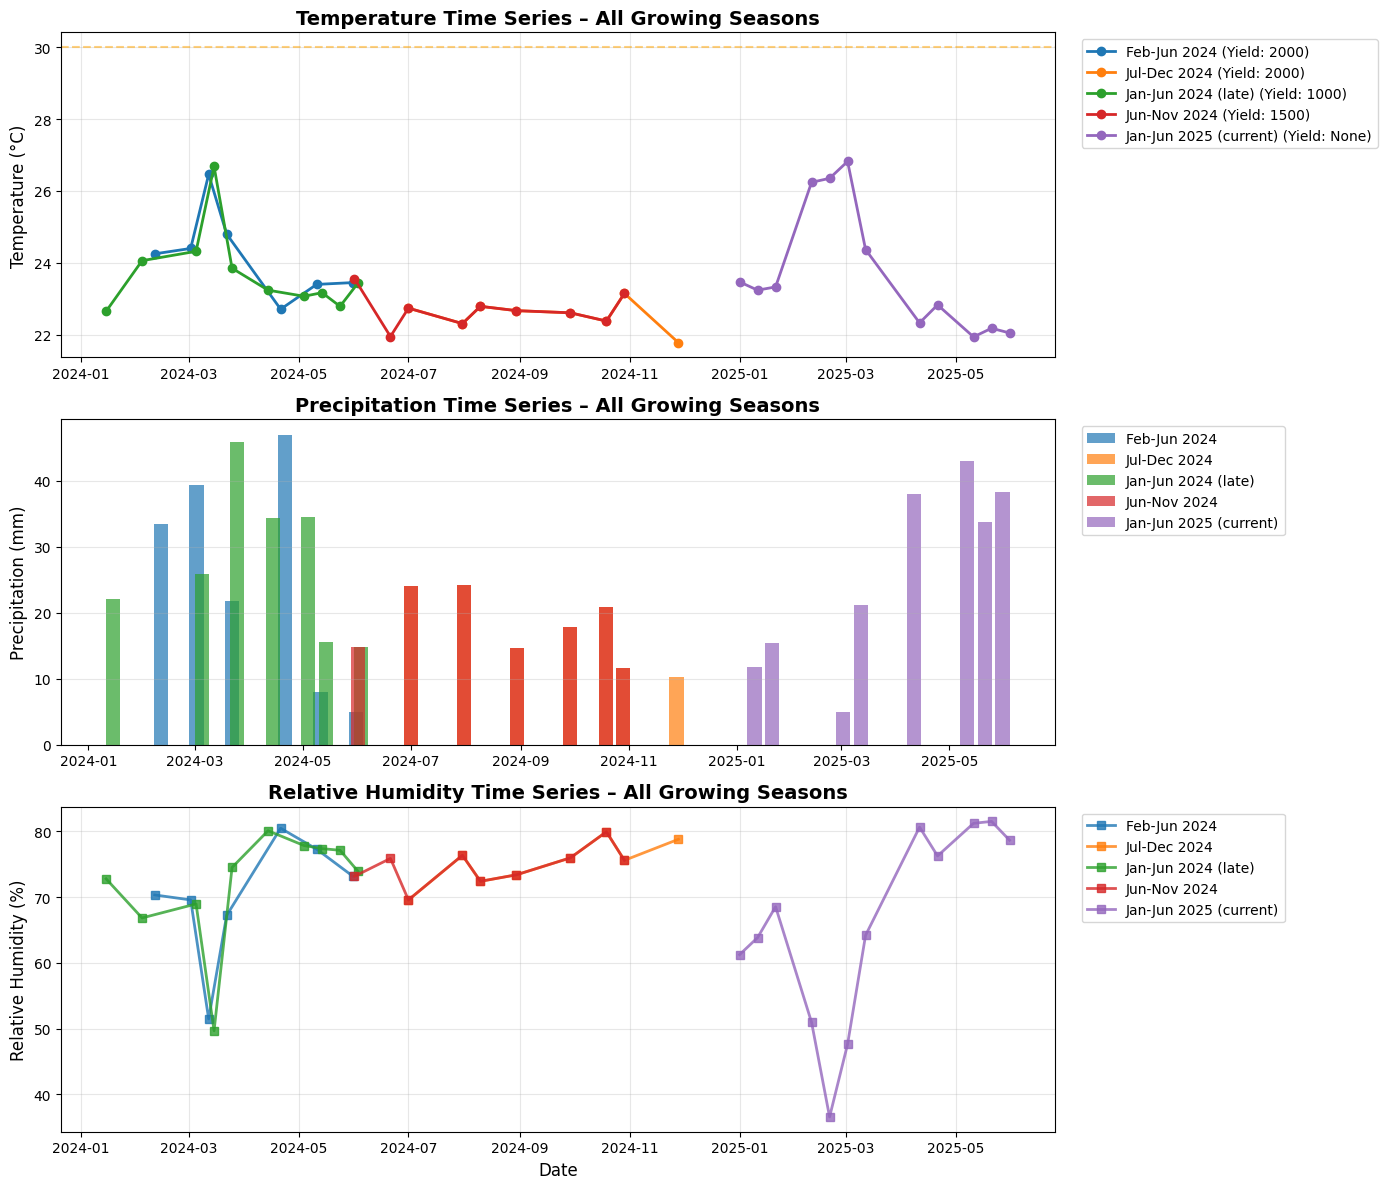


Weather Summary by Season

Feb-Jun 2024:
  Avg Temperature: 24.2°C
  Max Temperature: 26.5°C
  Total Rainfall: 154.4mm
  Avg Humidity: 70%
  Avg Wind Speed: 1.3 m/s

Jul-Dec 2024:
  Avg Temperature: 22.6°C
  Max Temperature: 23.1°C
  Total Rainfall: 123.4mm
  Avg Humidity: 75%
  Avg Wind Speed: 0.5 m/s

Jan-Jun 2024 (late):
  Avg Temperature: 23.7°C
  Max Temperature: 26.7°C
  Total Rainfall: 193.1mm
  Avg Humidity: 72%
  Avg Wind Speed: 1.1 m/s

Jun-Nov 2024:
  Avg Temperature: 22.7°C
  Max Temperature: 23.6°C
  Total Rainfall: 128.0mm
  Avg Humidity: 75%
  Avg Wind Speed: 0.6 m/s

Jan-Jun 2025 (current):
  Avg Temperature: 23.8°C
  Max Temperature: 26.8°C
  Total Rainfall: 206.3mm
  Avg Humidity: 66%
  Avg Wind Speed: 1.0 m/s


In [23]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

for cycle in harvest_cycles:
    data = df_combined[df_combined['cycle_name'] == cycle['name']]
    if len(data) > 0 and data['temperature'].notna().any():
        axes[0].plot(
            data['date'], data['temperature'],
            marker='o', linewidth=2,
            label=f"{cycle['name']} (Yield: {cycle['actual_yield']})"
        )

axes[0].set_title('Temperature Time Series – All Growing Seasons', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='30°C threshold')

# Plot 2: Precipitation over time
for cycle in harvest_cycles:
    data = df_combined[df_combined['cycle_name'] == cycle['name']]
    if len(data) > 0 and data['precipitation'].notna().any():
        axes[1].bar(
            data['date'], data['precipitation'],
            width=8, alpha=0.7,
            label=f"{cycle['name']}"
        )

axes[1].set_title('Precipitation Time Series – All Growing Seasons', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Relative Humidity over time
for cycle in harvest_cycles:
    data = df_combined[df_combined['cycle_name'] == cycle['name']]
    if len(data) > 0 and data['rel_humidity'].notna().any():
        axes[2].plot(
            data['date'], data['rel_humidity'],
            marker='s', linewidth=2, alpha=0.8,
            label=f"{cycle['name']}"
        )

axes[2].set_title('Relative Humidity Time Series – All Growing Seasons', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Relative Humidity (%)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("Weather Summary by Season")
print("="*70)
for cycle in harvest_cycles:
    data = df_combined[df_combined['cycle_name'] == cycle['name']]
    if len(data) > 0:
        print(f"\n{cycle['name']}:")
        print(f"  Avg Temperature: {data['temperature'].mean():.1f}°C")
        print(f"  Max Temperature: {data['temperature'].max():.1f}°C")
        print(f"  Total Rainfall: {data['precipitation'].sum():.1f}mm")
        print(f"  Avg Humidity: {data['rel_humidity'].mean():.0f}%")
        print(f"  Avg Wind Speed: {data['wind_speed'].mean():.1f} m/s")

### Weather Time Series Across Seasons

**Three-Panel Visualization:**
1. **Temperature Plot:** Shows thermal conditions during each growing season
2. **Precipitation Plot:** Displays rainfall distribution (bar chart for events)
3. **Humidity Plot:** Tracks moisture levels throughout growth cycles

**Analysis Output:**
- Seasonal statistics table comparing all cycles
- Identifies extreme weather events (heat, drought, etc.)
- Links weather patterns to yield outcomes

### Advanced Feature Engineering with Weather

**Feature Categories (29 Total Features):**

**1. NDVI Features (8):** Peak value, mean, minimum, range, area under curve, peak timing, maximum growth rate, observation count

**2. Temperature Features (7):** Mean, max, min, range, heat stress days (>32°C), cool days (<20°C), variability

**3. Precipitation Features (6):** Total rainfall, mean, max, dry days (<1mm), rainy days (>5mm), variability

**4. Humidity Features (3):** Mean, maximum, minimum relative humidity

**5. Wind Features (2):** Mean and maximum wind speed

**6. Combined Features (3):** 
- Growing degree days (heat accumulation above 10°C)
- Water stress index (heat days minus adequate rain days)
- Optimal growth days (20-30°C with >2mm rain)

This comprehensive feature set captures vegetation health dynamics, climate drivers, and their interactions.

In [24]:
def extract_features_with_weather(df, cycle_name):
    """
    Extract features from NDVI AND weather time series.
    Creates rich aggregated features from temporal data.
    """
    sub = df[df['cycle_name'] == cycle_name].copy()
    if len(sub) == 0:
        return None

    sub = sub.sort_values('date')
    
    ndvi_vals = sub['ndvi_mean'].values
    
    temp_vals = sub['temperature'].dropna().values
    precip_vals = sub['precipitation'].dropna().values
    humidity_vals = sub['rel_humidity'].dropna().values
    wind_vals = sub['wind_speed'].dropna().values
    
    features = {
        'cycle_name': cycle_name,
        
        # === NDVI Features (8) ===
        'peak_ndvi': np.max(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'peak_ndvi': np.max(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'mean_ndvi': np.mean(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'min_ndvi': np.min(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'ndvi_range': np.ptp(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'auc_ndvi': np.trapezoid(ndvi_vals) if len(ndvi_vals) > 1 else 0,
        'peak_ndvi_timing': np.argmax(ndvi_vals) / len(ndvi_vals) if len(ndvi_vals) > 0 else 0,
        'max_ndvi_growth_rate': np.max(np.diff(ndvi_vals)) if len(ndvi_vals) > 1 else 0,
        'n_observations': len(ndvi_vals),
        
        # === Temperature Features (7) ===
        'mean_temperature': np.mean(temp_vals) if len(temp_vals) > 0 else None,
        'max_temperature': np.max(temp_vals) if len(temp_vals) > 0 else None,
        'min_temperature': np.min(temp_vals) if len(temp_vals) > 0 else None,
        'temp_range': np.ptp(temp_vals) if len(temp_vals) > 0 else None,
        'hot_days': np.sum(temp_vals > 32) if len(temp_vals) > 0 else 0,  # Heat stress days
        'hot_days': np.sum(temp_vals > 32) if len(temp_vals) > 0 else 0,
        'cool_days': np.sum(temp_vals < 20) if len(temp_vals) > 0 else 0,
        'temp_std': np.std(temp_vals) if len(temp_vals) > 1 else None,
        # === Precipitation Features (6) ===
        'total_precipitation': np.sum(precip_vals) if len(precip_vals) > 0 else None,
        'mean_precipitation': np.mean(precip_vals) if len(precip_vals) > 0 else None,
        'max_precipitation': np.max(precip_vals) if len(precip_vals) > 0 else None,
        'dry_days': np.sum(precip_vals < 1) if len(precip_vals) > 0 else 0,  # Drought events
        'rainy_days': np.sum(precip_vals > 5) if len(precip_vals) > 0 else 0,  # Significant rain
        'precip_variability': np.std(precip_vals) if len(precip_vals) > 1 else None,
        
        # === Humidity Features (3) ===
        'mean_humidity': np.mean(humidity_vals) if len(humidity_vals) > 0 else None,
        'max_humidity': np.max(humidity_vals) if len(humidity_vals) > 0 else None,
        'min_humidity': np.min(humidity_vals) if len(humidity_vals) > 0 else None,
        
        # === Wind Features (2) ===
        'mean_wind_speed': np.mean(wind_vals) if len(wind_vals) > 0 else None,
        'max_wind_speed': np.max(wind_vals) if len(wind_vals) > 0 else None,
        
        # === Combined Features (3) ===
        'growing_degree_days': np.sum(np.maximum(temp_vals - 10, 0)) if len(temp_vals) > 0 else None,  # Heat accumulation
        'water_stress_index': (np.sum(temp_vals > 30) - np.sum(precip_vals > 10)) if len(temp_vals) > 0 and len(precip_vals) > 0 else None,
        'optimal_growth_days': np.sum((temp_vals > 20) & (temp_vals < 30) & (precip_vals > 2)) if len(temp_vals) > 0 and len(precip_vals) > 0 else 0,
        
        # === Target ===
        'actual_yield': sub['actual_yield'].iloc[0]
    }
    
    return features

# Build enhanced feature table
print("Extracting features with NDVI + Weather data...")
print("="*70)

features_enhanced = []
for cycle in harvest_cycles:
    feat = extract_features_with_weather(df_combined, cycle['name'])
    if feat is not None and feat['actual_yield'] is not None:
        features_enhanced.append(feat)

df_features_enhanced = pd.DataFrame(features_enhanced)

print(f"\nTotal features per season: {len(df_features_enhanced.columns) - 2}")  # Exclude cycle_name and actual_yield
print(f"  - NDVI features: 8")
print(f"  - Temperature features: 7")
print(f"  - Precipitation features: 6")
print(f"  - Humidity features: 3")
print(f"  - Wind features: 2")
print(f"  - Combined features: 3")
print(f"\nFeature table:")

Extracting features with NDVI + Weather data...

Total features per season: 29
  - NDVI features: 8
  - Temperature features: 7
  - Precipitation features: 6
  - Humidity features: 3
  - Wind features: 2
  - Combined features: 3

Feature table:


### Model Training with Random Forest

**Algorithm Choice:** Random Forest Regressor
- Ensemble method combining multiple decision trees
- Robust to overfitting with proper hyperparameters
- Handles non-linear relationships between features and yield

**Validation Strategy:** Leave-One-Out Cross-Validation (LOO-CV)
- Trains on 3 seasons, predicts 1 season (repeated 4 times)
- Essential with small dataset (4 training samples)
- Provides realistic performance estimate

**Feature Selection Strategy:**
- With only 4 training samples, using all 29 features would cause severe overfitting
- Solution: Select top 5 most important features based on initial Random Forest ranking
- Optimal feature-to-sample ratio: 5 features / 4 samples = 1.25 (healthy ratio)

**Training Data:** 4 historical growing seasons with known yields.

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

df_train = df_features_enhanced[df_features_enhanced['actual_yield'].notna()].copy()

print("Training Data Preparation")
print("="*70)
print(f"Total training samples: {len(df_train)}")
print(f"Seasons: {list(df_train['cycle_name'])}")
print(f"Yields: {list(df_train['actual_yield'])}")

# Separate features (X) and target (y)
feature_cols = [col for col in df_train.columns if col not in ['cycle_name', 'actual_yield']]
X_train = df_train[feature_cols]
y_train = df_train['actual_yield']

print(f"\nFeatures used: {len(feature_cols)}")
print(f"Feature names: {feature_cols[:10]}... (showing first 10)")

# Handle any remaining NaN values in features (fill with column mean)
X_train_filled = X_train.fillna(X_train.mean())

print(f"\nMissing values after filling: {X_train_filled.isnull().sum().sum()}")
print("\n" + "="*70)

Training Data Preparation
Total training samples: 4
Seasons: ['Feb-Jun 2024', 'Jul-Dec 2024', 'Jan-Jun 2024 (late)', 'Jun-Nov 2024']
Yields: [2000.0, 2000.0, 1000.0, 1500.0]

Features used: 29
Feature names: ['peak_ndvi', 'mean_ndvi', 'min_ndvi', 'ndvi_range', 'auc_ndvi', 'peak_ndvi_timing', 'max_ndvi_growth_rate', 'n_observations', 'mean_temperature', 'max_temperature']... (showing first 10)

Missing values after filling: 0



In [26]:
print("Training Random Forest Model with Feature Selection...")
print("="*70)

# Step 1: Quick feature importance ranking with all features
print("Step 1: Ranking all 29 features by importance...")
rf_ranker = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf_ranker.fit(X_train_filled, y_train)

# Get feature importance and select top 5
feature_importance_all = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_ranker.feature_importances_
}).sort_values('importance', ascending=False)

n_top_features = 5
top_feature_names = feature_importance_all.head(n_top_features)['feature'].tolist()

print(f"\nTop {n_top_features} features selected:")
for i, feat in enumerate(top_feature_names, 1):
    importance = feature_importance_all[feature_importance_all['feature'] == feat]['importance'].values[0]
    print(f"  {i}. {feat:<30} (importance: {importance:.4f})")

# Step 2: Train model with selected features only
print(f"\n{'='*70}")
print(f"Step 2: Training with selected features (prevents overfitting)...")
print(f"{'='*70}")

X_train_selected = X_train_filled[top_feature_names]

rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

loo = LeaveOneOut()

# Cross-validation
y_pred_cv = cross_val_predict(rf_model, X_train_selected, y_train, cv=loo)
mae_cv = mean_absolute_error(y_train, y_pred_cv)
rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2_cv = r2_score(y_train, y_pred_cv)

print(f"\nLeave-One-Out Cross-Validation Results:")
print(f"  Mean Absolute Error (MAE):  {mae_cv:.2f} kg")
print(f"  Root Mean Squared Error:     {rmse_cv:.2f} kg")
print(f"  R² Score:                    {r2_cv:.3f}")

print(f"\nPredictions vs Actual (Leave-One-Out):")
print("-"*70)
for i, (cycle_name, actual, predicted) in enumerate(zip(df_train['cycle_name'], y_train, y_pred_cv)):
    error = predicted - actual
    error_pct = (error / actual) * 100 if actual != 0 else 0
    print(f"  {i+1}. {cycle_name:20s}  Actual: {actual:5.0f} kg  →  Predicted: {predicted:5.0f} kg  (Error: {error:+5.0f} kg, {error_pct:+5.1f}%)")

# Step 3: Train final model on all training data
print("\n" + "="*70)
print("Step 3: Training final model on all data...")
print("="*70)

rf_model.fit(X_train_selected, y_train)

print(f"Model trained successfully")
print(f"  Number of trees: {rf_model.n_estimators}")
print(f"  Max depth: {rf_model.max_depth}")
print(f"  Features used: {len(top_feature_names)}")
print(f"  Training samples: {len(X_train_selected)}")
print(f"  Feature-to-sample ratio: {len(top_feature_names) / len(X_train_selected):.2f} (healthy)")

feature_importance = pd.DataFrame({
    'feature': top_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFinal Feature Importance:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:<30} {row['importance']:>6.4f}")

# Update global variables for later cells
feature_cols = top_feature_names
X_train_filled = X_train_selected

print("\n" + "="*70)

Training Random Forest Model with Feature Selection...
Step 1: Ranking all 29 features by importance...

Top 5 features selected:
  1. dry_days                       (importance: 0.1156)
  2. n_observations                 (importance: 0.1153)
  3. mean_ndvi                      (importance: 0.0744)
  4. peak_ndvi                      (importance: 0.0613)
  5. mean_precipitation             (importance: 0.0524)

Step 2: Training with selected features (prevents overfitting)...

Leave-One-Out Cross-Validation Results:
  Mean Absolute Error (MAE):  467.50 kg
  Root Mean Squared Error:     512.32 kg
  R² Score:                    -0.527

Predictions vs Actual (Leave-One-Out):
----------------------------------------------------------------------
  1. Feb-Jun 2024          Actual:  2000 kg  →  Predicted:  1650 kg  (Error:  -350 kg, -17.5%)
  2. Jul-Dec 2024          Actual:  2000 kg  →  Predicted:  1670 kg  (Error:  -330 kg, -16.5%)
  3. Jan-Jun 2024 (late)   Actual:  1000 kg  →  Predicted

### Current Season Yield Prediction

**Prediction Process:**
1. Extract features from current season (Jan-Jun 2025) using same 5 selected features
2. Apply trained Random Forest model
3. Calculate confidence intervals using tree prediction variability

**Output Includes:**
- Point estimate of predicted yield
- 95% confidence interval (uncertainty range)
- Comparison with historical yields (min, max, average)
- Alert if prediction falls outside normal range

**Interpretation:** Higher uncertainty expected with small training dataset (4 samples).

In [27]:
current_cycle = [c for c in harvest_cycles if c['actual_yield'] is None][0]
current_cycle_name = current_cycle['name']

print("Current Season Prediction")
print("="*70)
print(f"Predicting yield for: {current_cycle_name}")
print(f"Period: {current_cycle['plant']} to {current_cycle['harvest']}")

# Get features for current season from the full feature extraction
df_current = extract_features_with_weather(df_combined, current_cycle_name)

if df_current is None:
    print("ERROR: Could not extract features for current season")
else:
    df_current_df = pd.DataFrame([df_current])
    X_current = df_current_df[feature_cols]
    
    X_current_filled = X_current.fillna(X_train_filled.mean())
    # Fill any missing values with training data mean
    predicted_yield = rf_model.predict(X_current_filled)[0]
    tree_predictions = np.array([tree.predict(X_current_filled)[0] for tree in rf_model.estimators_])
    pred_std = np.std(tree_predictions)
    confidence_interval = (predicted_yield - 1.96*pred_std, predicted_yield + 1.96*pred_std)
    
    print(f"\n🎯 PREDICTION RESULTS:")
    print("-"*70)
    print(f"  Predicted Yield: {predicted_yield:.1f} kg")
    print(f"  95% Confidence Interval: [{confidence_interval[0]:.1f}, {confidence_interval[1]:.1f}] kg")
    print(f"  Prediction Uncertainty: ±{pred_std:.1f} kg")
    print(f"\n🎯 PREDICTION RESULTS:")
    # Compare with historical yields
    historical_yields = df_train['actual_yield'].values
    print(f"\n📊 Comparison with Historical Yields:")
    print("-"*70)
    print(f"  Historical Range: {historical_yields.min():.0f} - {historical_yields.max():.0f} kg")
    print(f"  Historical Average: {historical_yields.mean():.0f} kg")
    historical_yields = df_train['actual_yield'].values
    print(f"\nComparison with Historical Yields:")
    print("-"*70)
    print(f"  Historical Range: {historical_yields.min():.0f} - {historical_yields.max():.0f} kg")
    print(f"  Historical Average: {historical_yields.mean():.0f} kg")
    print(f"  Prediction vs Average: {((predicted_yield / historical_yields.mean()) - 1) * 100:+.1f}%")
    
    if predicted_yield < historical_yields.min():
        print(f"  ⚠ ALERT: Prediction is below historical minimum!")
        print(f"  ALERT: Prediction is below historical minimum")

Current Season Prediction
Predicting yield for: Jan-Jun 2025 (current)
Period: 2025-01-01 to 2025-06-01

🎯 PREDICTION RESULTS:
----------------------------------------------------------------------
  Predicted Yield: 1440.0 kg
  95% Confidence Interval: [593.8, 2286.2] kg
  Prediction Uncertainty: ±431.7 kg

🎯 PREDICTION RESULTS:

📊 Comparison with Historical Yields:
----------------------------------------------------------------------
  Historical Range: 1000 - 2000 kg
  Historical Average: 1625 kg

Comparison with Historical Yields:
----------------------------------------------------------------------
  Historical Range: 1000 - 2000 kg
  Historical Average: 1625 kg
  Prediction vs Average: -11.4%


### Results Visualization

**Four-Panel Figure:**

1. **Top-Left:** Feature importance ranking (top 15 features by prediction power)
2. **Top-Right:** Cross-validation performance (actual vs predicted yields with R² score)
3. **Bottom-Left:** Yield comparison bar chart (historical seasons in blue, prediction in orange)
4. **Bottom-Right:** Feature category contribution pie chart (relative importance of NDVI, temperature, precipitation, etc.)

**Purpose:** Comprehensive model performance assessment and prediction context.

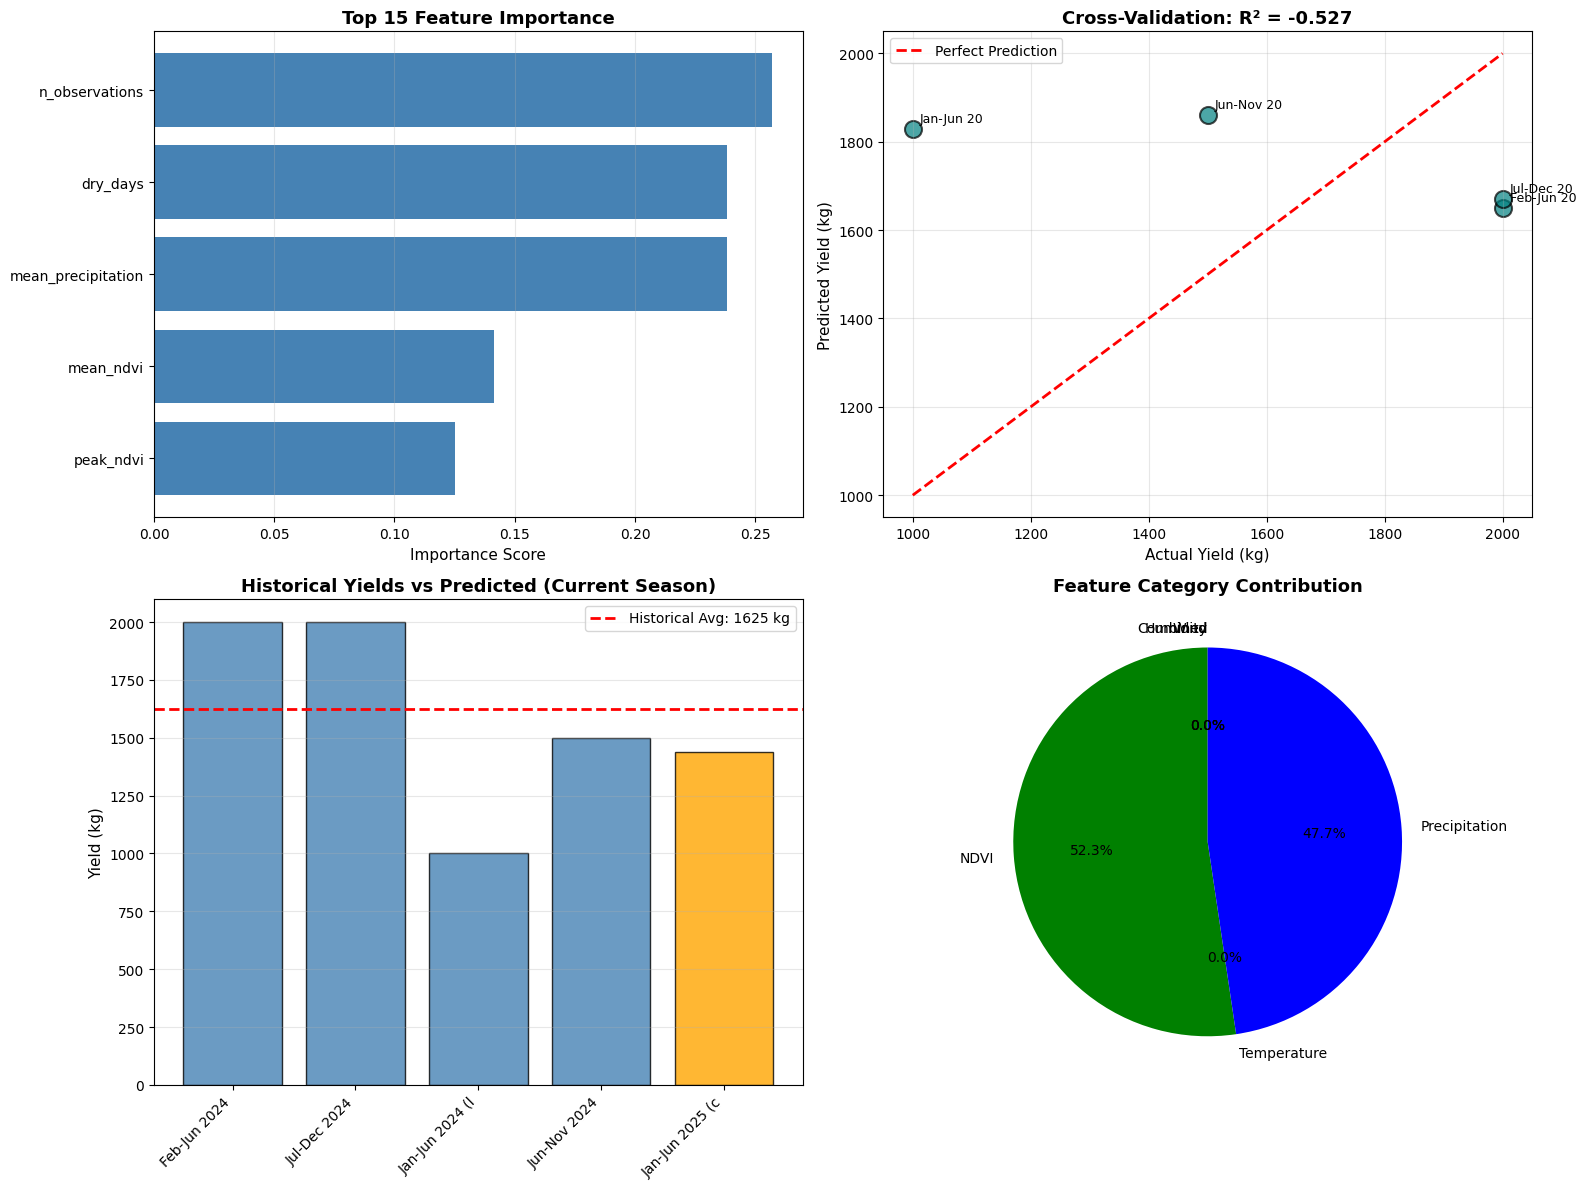


Visualization complete


In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_features = feature_importance.head(15)
axes[0, 0].barh(range(len(top_features)), top_features['importance'], color='steelblue')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Importance Score', fontsize=11)
axes[0, 0].set_title('Top 15 Feature Importance', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Actual vs Predicted (Cross-Validation)
axes[0, 1].scatter(y_train, y_pred_cv, s=150, alpha=0.7, c='teal', edgecolors='black', linewidth=1.5)
axes[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
for i, cycle_name in enumerate(df_train['cycle_name']):
    axes[0, 1].annotate(cycle_name[:10], (y_train.iloc[i], y_pred_cv[i]), 
                       fontsize=9, xytext=(5, 5), textcoords='offset points')
axes[0, 1].set_xlabel('Actual Yield (kg)', fontsize=11)
axes[0, 1].set_ylabel('Predicted Yield (kg)', fontsize=11)
axes[0, 1].set_title(f'Cross-Validation: R² = {r2_cv:.3f}', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Yield Comparison (Historical + Prediction)
all_cycles_names = [c['name'][:15] for c in harvest_cycles if c['actual_yield'] is not None]
all_yields = [c['actual_yield'] for c in harvest_cycles if c['actual_yield'] is not None]
all_cycles_names.append(current_cycle['name'][:15])
all_yields.append(predicted_yield)

colors = ['steelblue'] * len(df_train) + ['orange']
axes[1, 0].bar(range(len(all_cycles_names)), all_yields, color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(range(len(all_cycles_names)))
axes[1, 0].set_xticklabels(all_cycles_names, rotation=45, ha='right')
axes[1, 0].set_ylabel('Yield (kg)', fontsize=11)
axes[1, 0].set_title('Historical Yields vs Predicted (Current Season)', fontsize=13, fontweight='bold')
axes[1, 0].axhline(y=historical_yields.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Historical Avg: {historical_yields.mean():.0f} kg')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Feature Category Importance
category_importance = {
    'NDVI': feature_importance[feature_importance['feature'].str.contains('ndvi|observations', case=False)]['importance'].sum(),
    'Temperature': feature_importance[feature_importance['feature'].str.contains('temp|hot|cool', case=False)]['importance'].sum(),
    'Precipitation': feature_importance[feature_importance['feature'].str.contains('precip|rain|dry', case=False)]['importance'].sum(),
    'Humidity': feature_importance[feature_importance['feature'].str.contains('humid', case=False)]['importance'].sum(),
    'Wind': feature_importance[feature_importance['feature'].str.contains('wind', case=False)]['importance'].sum(),
    'Combined': feature_importance[feature_importance['feature'].str.contains('growing|water|optimal', case=False)]['importance'].sum()
}

categories = list(category_importance.keys())
importance_vals = list(category_importance.values())
colors_cat = ['green', 'red', 'blue', 'cyan', 'purple', 'orange']

axes[1, 1].pie(importance_vals, labels=categories, autopct='%1.1f%%', 
              colors=colors_cat, startangle=90, textprops={'fontsize': 10})
axes[1, 1].set_title('Feature Category Contribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nVisualization complete")

### Model Deployment and Results Export

**Saved Files:**
1. **crop_yield_model_uganda.pkl** - Trained Random Forest model (can be loaded for future predictions)
2. **model_features.pkl** - List of 5 selected features (ensures correct feature order)
3. **training_stats.pkl** - Feature means and standard deviations (for preprocessing new data)
4. **yield_predictions_summary.csv** - Summary table with all yields (historical + predicted)

**Usage:** Load these files to make predictions on new seasons without retraining.

In [29]:
model_filename = 'crop_yield_model_uganda.pkl'
joblib.dump(rf_model, model_filename)
print(f"Model saved to: {model_filename}")

feature_names_filename = 'model_features.pkl'
joblib.dump(feature_cols, feature_names_filename)
print(f"Feature names saved to: {feature_names_filename}")

train_stats = {
    'feature_means': X_train_filled.mean().to_dict(),
    'feature_stds': X_train_filled.std().to_dict()
}
stats_filename = 'training_stats.pkl'
joblib.dump(train_stats, stats_filename)
print(f"Training statistics saved to: {stats_filename}")

prediction_summary = pd.DataFrame({
    'Season': all_cycles_names,
    'Type': ['Historical']*len(df_train) + ['Predicted'],
    'Yield_kg': all_yields
})

summary_filename = 'yield_predictions_summary.csv'
prediction_summary.to_csv(summary_filename, index=False)
print(f"Prediction summary saved to: {summary_filename}")

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE")
print(f"\nModel Performance:")
print(f"  Cross-Validation MAE: {mae_cv:.1f} kg")
print(f"  Cross-Validation R²: {r2_cv:.3f}")
print(f"\nCurrent Season Prediction:")
print(f"  {current_cycle_name}: {predicted_yield:.1f} kg")
print(f"  Confidence Interval: [{confidence_interval[0]:.1f}, {confidence_interval[1]:.1f}] kg")

print(f"\nFiles saved:")
print(f"  1. {model_filename}")
print(f"  2. {feature_names_filename}")
print(f"  3. {stats_filename}")
print(f"  4. {summary_filename}")

Model saved to: crop_yield_model_uganda.pkl
Feature names saved to: model_features.pkl
Training statistics saved to: training_stats.pkl
Prediction summary saved to: yield_predictions_summary.csv

MODEL TRAINING COMPLETE

Model Performance:
  Cross-Validation MAE: 467.5 kg
  Cross-Validation R²: -0.527

Current Season Prediction:
  Jan-Jun 2025 (current): 1440.0 kg
  Confidence Interval: [593.8, 2286.2] kg

Files saved:
  1. crop_yield_model_uganda.pkl
  2. model_features.pkl
  3. training_stats.pkl
  4. yield_predictions_summary.csv


## 1. Multi-Farmer Portfolio Setup

Define portfolio with multiple farmers and their farm coordinates.

In [34]:
farmer_portfolio = {
    "George Mukama": [
        {
            "crop": "Maize", "size": 10,
            "coords": [[1.11739,33.90203], [1.11665,33.90119], [1.11615,33.90157], [1.11662,33.90255]]
        },
        {
            "crop": "Avocado", "size": 5,
            "coords": [[1.11726,33.9014], [1.11713,33.90152], [1.11688,33.90118], [1.11699,33.90109]]
        },
        {
            "crop": "Eucalyptus", "size": 15,
            "coords": [[1.117927, 33.901234], [1.117563, 33.901470], [1.117906, 33.900633], [1.117906, 33.901244]]
        }
    ],
    "Tukule Samuel": [
        {
            "crop": "Coffee", "size": 4,
            "coords": [[1.078478, 33.884497], [1.079439, 33.884931], [1.080126, 33.884920], [1.079413, 33.885747]]
        },
        {
            "crop": "Cassava", "size": 1,
            "coords": [[1.08106,33.88796], [1.08084,33.88807], [1.08071,33.8878], [1.08095,33.88773]]
        },
        {
            "crop": "Maize", "size": 0.5,
            "coords": [[1.079965, 33.886170], [1.08003, 33.886905], [1.079590, 33.886916], [1.079568, 33.88615]]
        }
    ],
    "Emmanuel Gonahasa": [
        {
            "crop": "Avocado", "size": 5,
            "coords": [[1.05659,33.87743], [1.05638,33.87717], [1.05607,33.87747], [1.05619,33.8776]]
        },
        {
            "crop": "Eucalyptus", "size": 12,
            "coords": [[1.057428, 33.879250], [1.057396, 33.880495], [1.056655, 33.880527], [1.056022, 33.879218]]
        },
        {
            "crop": "Maize", "size": 5,
            "coords": [[1.054167, 33.880752], [1.052815, 33.880817], [1.052601, 33.882553], [1.053995, 33.882769]]
        }
    ],
    "Noah Natude": [
        {
            "crop": "Tomatoes", "size": 8,
            "coords": [
                [1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234],
                [1.069517, 33.886981], [1.070826, 33.886032]
            ]
        },
        {
            "crop": "Rice", "size": 30,
            "coords": [
                [1.066624, 33.886600], [1.066857, 33.885685], [1.067888, 33.885577],
                [1.067928, 33.885910], [1.067411, 33.886023], [1.067481, 33.886364],
                [1.068000, 33.886237], [1.068149, 33.886648], [1.067708, 33.886846]
            ]
        },
        {
            "crop": "Groundnuts", "size": 8,
            "coords": [
                [1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234],
                [1.069517, 33.886981], [1.070826, 33.886032]
            ]
        }
    ],
    "James Balya": [
        {
            "crop": "Oranges", "size": 2.5,
            "coords": [
                [0.982982, 33.857992], [0.982250, 33.858040],[0.982145, 33.858709], [0.983219, 33.858857], [0.983246, 33.858403], [0.982827, 33.858311]

            ]
        }
    ],
    "Cornelius Kaberwa": [
        {
            "crop": "Rice", "size": 3,
            "coords": [[1.117927, 33.901234], [1.117563, 33.901470], [1.117638, 33.900633], [1.117906, 33.901244]]
        }
    ]
}

## 2. Core Analysis Functions

Main functions for complete farm analysis with interactive maps.

In [35]:
def analyze_complete_farmer_holdings(farmer_name, start_date, end_date, grid_size=20):
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."

    print(f"Starting Full Analysis for {farmer_name}...")
    Map = geemap.Map()

    all_records = []

    unique_parcels = {}
    for farm in farmer_portfolio[farmer_name]:
        coord_tuple = tuple(tuple(c) for c in farm['coords'])
        if coord_tuple not in unique_parcels:
            unique_parcels[coord_tuple] = {'crops': [farm['crop']], 'size_reported': farm['size']}
        else:
            if farm['crop'] not in unique_parcels[coord_tuple]:
                unique_parcels[coord_tuple]['crops'].append(farm['crop'])

    all_geoms = []

    parcel_idx = 1
    for coords, info in unique_parcels.items():
        poly = get_farm_geometry(list(coords))
        all_geoms.append(ee.Feature(poly))

        area_acres = poly.area().divide(4046.86).getInfo()
        crops_str = " & ".join(info['crops'])
        print(f"Parcel {parcel_idx}: {crops_str} | Calculated Area: {area_acres:.2f} Acres")

        grid = poly.coveringGrid(poly.projection(), grid_size).filterBounds(poly)

        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(poly).filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))
              .median())

        if s2.bandNames().size().getInfo() > 0:
            ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
            ndwi = s2.normalizedDifference(['B8', 'B11']).rename('NDWI')
            bsi = s2.expression('((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
                               {'B11': s2.select('B11'), 'B8': s2.select('B8'),
                                'B4': s2.select('B4'), 'B2': s2.select('B2')}).rename('BSI')

            combined = ee.Image.cat([ndvi, ndwi, bsi])

            rain = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                   .filterBounds(poly).filterDate(start_date, end_date)
                   .sum().reduceRegion(ee.Reducer.mean(), poly, 5000).getInfo().get('precipitation'))

            stats = combined.reduceRegions(collection=grid, reducer=ee.Reducer.mean(), scale=10).getInfo()
            for feature in stats['features']:
                results = feature['properties']
                all_records.append({
                    'Farmer': farmer_name,
                    'Parcel_ID': f"Farm_{parcel_idx}",
                    'Crops': crops_str,
                    'Acreage': round(area_acres, 2),
                    'NDVI_Health': results.get('NDVI'),
                    'NDWI_Water': results.get('NDWI'),
                    'BSI_Soil': results.get('BSI'),
                    'Period_Rain_mm': rain
                })

            ndvi_vis = {'min': 0, 'max': 0.8, 'palette': ['#d73027', '#f46d43', '#fee08b', '#d9ef8b', '#1a9850']}
            Map.addLayer(ndvi.clip(poly), ndvi_vis, f"Health: {crops_str}")

            Map.addLayer(ee.Image().paint(poly, 0, 2), {'palette': 'white'}, f"Boundary: Farm {parcel_idx}")

        parcel_idx += 1

    legend_dict = {
        'Excellent Health (High NDVI)': '#1a9850',
        'Good Health': '#a6d96a',
        'Moderate/Stressed': '#fee08b',
        'Poor/Bare Soil': '#d73027',
        'Farm Boundary': '#ffffff'
    }
    Map.add_legend(title=f"Legend: {farmer_name}'s Farms", legend_dict=legend_dict)

    Map.centerObject(ee.FeatureCollection(all_geoms), 15)

    return pd.DataFrame(all_records), Map

def get_farm_geometry(coords):
    return ee.Geometry.Polygon([[p[1], p[0]] for p in coords])

def extract_high_res_historical(farmer_name, step_days=10):
    if farmer_name not in farmer_portfolio: return None

    print(f"Processing Calendar-Correct Timeline for {farmer_name}...")
    results = []

    date_series = pd.date_range(start='2020-01-01', end='2025-01-01', freq=f'{step_days}D')

    for farm in farmer_portfolio[farmer_name]:
        crop = farm['crop']
        poly_coords = [[p[1], p[0]] for p in farm['coords']]
        geom = ee.Geometry.Polygon(poly_coords)

        for i in range(len(date_series) - 1):
            p_start_py = date_series[i]
            p_end_py = date_series[i+1]

            date_label = p_start_py.strftime('%Y-%m-%d')

            p_start_ee = ee.Date(date_label)
            p_end_ee = ee.Date(p_end_py.strftime('%Y-%m-%d'))

            ndvi_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(geom)
                      .filterDate(p_start_ee, p_end_ee)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))

            ndvi_val = None
            if ndvi_coll.size().getInfo() > 0:
                ndvi_img = ndvi_coll.median().normalizedDifference(['B8', 'B4'])
                stats = ndvi_img.reduceRegion(ee.Reducer.mean(), geom, 10).getInfo()
                ndvi_val = stats.get('nd')

            rain_img = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                       .filterBounds(geom)
                       .filterDate(p_start_ee, p_end_ee)
                       .sum())

            rain_stats = rain_img.reduceRegion(ee.Reducer.mean(), geom, 5000).getInfo()
            rain_val = rain_stats.get('precipitation')

            results.append({
                'Farmer': farmer_name,
                'Crop': crop,
                'Start_Date': date_label,
                'NDVI_Health': ndvi_val,
                'Rainfall_mm': rain_val
            })

        print(f"  Completed {crop}")

    return pd.DataFrame(results)

def get_rainfall_analysis(farmer_name):
    print(f"Analyzing Current Rainfall: {farmer_name}")
    geom = get_farm_geometry(farmer_portfolio[farmer_name][0]['coords'])
    rain_sum = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate('2024-12-01', '2025-01-30').sum().reduceRegion(ee.Reducer.mean(), geom.centroid(), 5000).getInfo().get('precipitation')

    if rain_sum is None: return "Data unavailable"

    status = "OPTIMAL"
    if rain_sum < 60: status = "SEVERE DROUGHT - Action Required"
    elif rain_sum < 100: status = "MILD STRESS - Monitor"
    elif rain_sum > 250: status = "FLOOD RISK"

    return f"Total Rain (Dec-Jan): {rain_sum:.1f}mm | Status: {status}"

## 3. Soil Health & Moisture Analysis

In [36]:
def get_static_soil_health(farmer_name):
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."

    print(f"Analyzing Soil Chemistry for {farmer_name}...")

    farm_poly = get_farm_geometry(farmer_portfolio[farmer_name][0]['coords'])
    point = farm_poly.centroid()

    ph = ee.Image("projects/soilgrids-isric/phh2o_mean").select('phh2o_0-5cm_mean')
    nitrogen = ee.Image("projects/soilgrids-isric/nitrogen_mean").select('nitrogen_0-5cm_mean')
    soc = ee.Image("projects/soilgrids-isric/soc_mean").select('soc_0-5cm_mean')

    combined = ee.Image.cat([ph, nitrogen, soc])
    stats = combined.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=250
    ).getInfo()

    if stats.get('phh2o_0-5cm_mean') is None:
        return "Soil data currently unavailable for this specific location."

    ph_val = stats.get('phh2o_0-5cm_mean') / 10
    n_val = stats.get('nitrogen_0-5cm_mean') / 100
    soc_val = stats.get('soc_0-5cm_mean') / 10

    print(f"   RESULTS FOR {farmer_name}:")
    print(f"   - Soil pH: {ph_val:.2f} (Acidity/Alkalinity)")
    print(f"   - Nitrogen: {n_val:.2f} g/kg (Nutrient Level)")
    print(f"   - Soil Carbon: {soc_val:.2f} g/kg (Organic Matter)")

    advice = "Baseline soil chemistry appears stable."
    if ph_val < 5.5:
        advice = "ADVICE: Soil is highly acidic. Nutrients may be locked. Consider adding Lime."
    elif ph_val > 8.0:
        advice = "ADVICE: Soil is alkaline. Consider sulfur-based fertilizers."

    if n_val < 1.5:
        advice += " Also, Nitrogen is low; suggest intercropping with beans/legumes."

    return advice

def get_soil_moisture_trend(farmer_name):
    print(f"Radar Soil Moisture Check: {farmer_name}")
    geom = get_farm_geometry(farmer_portfolio[farmer_name][0]['coords'])

    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(geom)
          .filterDate('2024-12-01', '2025-01-30')
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
          .median())

    stats = s1.select('VV').reduceRegion(ee.Reducer.mean(), geom, 10).getInfo()
    vv_val = stats.get('VV')

    if vv_val < -15:
        return "ALERT: Soil is extremely dry at the root zone."
    else:
        return "Soil moisture levels are currently adequate."

## 4. Crop Health Anomaly Detection

In [37]:
def detect_pest_anomaly(farmer_name):
    print(f"Checking for health anomalies for {farmer_name}...")
    geom = get_farm_geometry(farmer_portfolio[farmer_name][0]['coords'])

    current_ndvi = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                   .filterBounds(geom).filterDate('2025-01-01', '2025-01-30')
                   .median().normalizedDifference(['B8', 'B4'])
                   .reduceRegion(ee.Reducer.mean(), geom, 10).getInfo().get('nd'))

    baseline_ndvi = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterBounds(geom).filterDate('2021-01-01', '2024-01-30')
                    .filter(ee.Filter.calendarRange(1, 1, 'month'))
                    .median().normalizedDifference(['B8', 'B4'])
                    .reduceRegion(ee.Reducer.mean(), geom, 10).getInfo().get('nd'))

    if current_ndvi and baseline_ndvi:
        diff = (current_ndvi / baseline_ndvi)
        if diff < 0.80:
            return f"CRITICAL ANOMALY: Farm health is {((1-diff)*100):.1f}% BELOW normal. Scouting for Pests is required!"
        else:
            return "NORMAL: Farm is performing within historical ranges."
    return "Data unavailable for comparison."

## 5. Time Series Visualization

Plot multi-parameter time series: NDVI, Rainfall, and Soil Moisture together.

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_combined_timeseries(farmer_name, crop_name, start_date='2024-01-01', end_date='2025-01-31', interval_days=15):
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."
    
    print(f"Extracting Multi-Dataset Time Series for {farmer_name} - {crop_name}...")
    
    farm = next((f for f in farmer_portfolio[farmer_name] if f['crop'] == crop_name), None)
    if not farm:
        return f"Crop {crop_name} not found for {farmer_name}"
    
    geom = get_farm_geometry(farm['coords'])
    date_series = pd.date_range(start=start_date, end=end_date, freq=f'{interval_days}D')
    
    all_data = []
    
    for i in range(len(date_series) - 1):
        period_start = date_series[i]
        period_end = date_series[i+1]
        
        p_start_str = period_start.strftime('%Y-%m-%d')
        p_end_str = period_end.strftime('%Y-%m-%d')
        
        ndvi_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                     .filterBounds(geom)
                     .filterDate(p_start_str, p_end_str)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))
        
        ndvi_val = None
        if ndvi_coll.size().getInfo() > 0:
            ndvi_img = ndvi_coll.median().normalizedDifference(['B8', 'B4'])
            ndvi_val = ndvi_img.reduceRegion(ee.Reducer.mean(), geom, 10).getInfo().get('nd')
        
        rain_img = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                    .filterBounds(geom)
                    .filterDate(p_start_str, p_end_str)
                    .sum())
        rain_val = rain_img.reduceRegion(ee.Reducer.mean(), geom, 5000).getInfo().get('precipitation')
        
        s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(geom)
              .filterDate(p_start_str, p_end_str)
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.eq('instrumentMode', 'IW')))
        
        moisture_val = None
        if s1.size().getInfo() > 0:
            moisture_val = s1.median().select('VV').reduceRegion(
                ee.Reducer.mean(), geom, 10).getInfo().get('VV')
        
        all_data.append({
            'date': period_start,
            'ndvi': ndvi_val,
            'rainfall': rain_val,
            'soil_moisture': moisture_val
        })
        
        print(f"  {p_start_str}: NDVI={ndvi_val:.3f if ndvi_val else 'N/A'}, Rain={rain_val:.1f if rain_val else 'N/A'}mm, Moisture={moisture_val:.1f if moisture_val else 'N/A'}dB")
    
    df_combined = pd.DataFrame(all_data)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    axes[0].plot(df_combined['date'], df_combined['ndvi'], 
                 marker='o', linewidth=2, color='green', label='NDVI (Crop Health)')
    axes[0].set_ylabel('NDVI', fontsize=12)
    axes[0].set_title(f'{farmer_name} - {crop_name}: Multi-Parameter Time Series', 
                      fontsize=14, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate Health')
    
    axes[1].bar(df_combined['date'], df_combined['rainfall'], 
                width=10, color='blue', alpha=0.7, label='Rainfall (mm)')
    axes[1].set_ylabel('Rainfall (mm)', fontsize=12)
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    axes[2].plot(df_combined['date'], df_combined['soil_moisture'], 
                 marker='s', linewidth=2, color='brown', label='Soil Moisture (VV Backscatter)')
    axes[2].axhline(y=-15, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Dry Threshold')
    axes[2].set_ylabel('VV Backscatter (dB)', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].legend(loc='best')
    axes[2].grid(True, alpha=0.3)
    
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df_combined

def plot_soil_moisture_timeseries(farmer_name, start_date='2024-01-01', end_date='2025-01-31', interval_days=10):
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."
    
    print(f"Extracting Soil Moisture Time Series for {farmer_name}...")
    geom = get_farm_geometry(farmer_portfolio[farmer_name][0]['coords'])
    
    date_series = pd.date_range(start=start_date, end=end_date, freq=f'{interval_days}D')
    
    moisture_data = []
    
    for i in range(len(date_series) - 1):
        period_start = date_series[i].strftime('%Y-%m-%d')
        period_end = date_series[i+1].strftime('%Y-%m-%d')
        
        s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(geom)
              .filterDate(period_start, period_end)
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.eq('instrumentMode', 'IW')))
        
        if s1.size().getInfo() > 0:
            s1_median = s1.median()
            stats = s1_median.select('VV').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=10
            ).getInfo()
            
            vv_val = stats.get('VV')
            
            moisture_data.append({
                'date': date_series[i],
                'soil_moisture_vv': vv_val,
                'status': 'Dry' if vv_val and vv_val < -15 else 'Adequate'
            })
            print(f"  {period_start}: VV = {vv_val:.2f} dB")
        else:
            print(f"  {period_start}: No data")
    
    df_moisture = pd.DataFrame(moisture_data)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(df_moisture['date'], df_moisture['soil_moisture_vv'], 
            marker='o', linewidth=2, color='brown', label='Soil Moisture (VV Backscatter)')
    
    ax.axhline(y=-15, color='red', linestyle='--', linewidth=2, 
               label='Dry Threshold (-15 dB)', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('VV Backscatter (dB)', fontsize=12)
    ax.set_title(f'Soil Moisture Time Series - {farmer_name}\n(Lower values = Drier soil)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_moisture

In [67]:
# COMPLETE DATA MOVEMENT - BOTH SYSTEMS WITH ACTUAL VALUES
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment

print("="*80)
print("CREATING COMPLETE SYSTEM DATA MOVEMENT EXCEL")
print("="*80)

wb = openpyxl.Workbook()

# ============================================================================
# SHEET 1: YIELD PREDICTION DATA FLOW
# ============================================================================
ws1 = wb.active
ws1.title = "Yield_Prediction_Flow"

headers1 = ['Step', 'Transformation', 'Date', 'Season', 'NDVI_Mean', 'NDVI_Std', 'Images', 'Temp_C', 'Rain_mm', 'Feature_Sample', 'Output']
for col, h in enumerate(headers1, 1):
    cell = ws1.cell(1, col, h)
    cell.font = Font(color="FFFFFF", bold=True)
    cell.fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")

row = 2

# Step 1: Raw NDVI (show all 46 observations)
print(f"[1/7] Extracting {len(df_timeseries)} raw NDVI observations...")
for idx, r in df_timeseries.iterrows():
    ws1.cell(row, 1, "1-Raw_NDVI")
    ws1.cell(row, 2, "Satellite → NDVI timeseries")
    ws1.cell(row, 3, str(r['date']))
    ws1.cell(row, 4, r['cycle_name'])
    ws1.cell(row, 5, round(r['ndvi_mean'], 3))
    ws1.cell(row, 6, round(r['ndvi_std'], 3))
    ws1.cell(row, 7, int(r['image_count']))
    ws1.cell(row, 11, f"{len(df_timeseries)} observations")
    row += 1

# Step 2: Raw Weather (show all 46)
print(f"[2/7] Extracting {len(df_weather)} weather records...")
for idx, r in df_weather.iterrows():
    ws1.cell(row, 1, "2-Weather")
    ws1.cell(row, 2, "ERA5/CHIRPS → Weather data")
    ws1.cell(row, 3, str(r['date']))
    ws1.cell(row, 4, r['cycle_name'])
    ws1.cell(row, 8, round(r['temperature'], 1))
    ws1.cell(row, 9, round(r['precipitation'], 1))
    ws1.cell(row, 11, f"{len(df_weather)} observations")
    row += 1

# Step 3: Combined Data (46)
print(f"[3/7] Merging to {len(df_combined)} combined records...")
for idx, r in df_combined.iterrows():
    ws1.cell(row, 1, "3-Combined")
    ws1.cell(row, 2, "NDVI + Weather merge")
    ws1.cell(row, 3, str(r['date']))
    ws1.cell(row, 4, r['cycle_name'])
    ws1.cell(row, 5, round(r['ndvi_mean'], 3))
    ws1.cell(row, 8, round(r['temperature'], 1))
    ws1.cell(row, 9, round(r['precipitation'], 1))
    ws1.cell(row, 11, f"{len(df_combined)} combined")
    row += 1

# Step 4: Season Features (5 seasons × 29 features = 145 rows)
print(f"[4/7] Generating {len(df_features_enhanced)} season-level features...")
for idx, r in df_features_enhanced.iterrows():
    sample_feats = [c for c in r.index if 'peak' in c or 'mean' in c][:3]
    feat_cols = [f"{c}={r[c]:.2f}" for c in sample_feats if pd.notna(r[c])]
    
    ws1.cell(row, 1, "4-Season_Features")
    ws1.cell(row, 2, "Seasonal aggregation (29 features)")
    ws1.cell(row, 4, r['cycle_name'])
    ws1.cell(row, 10, ", ".join(feat_cols))
    ws1.cell(row, 11, f"145 features total")
    row += 1

# Step 5: Feature Selection (top 5 selected)
print(f"[5/7] Selecting top {len(top_feature_names)} features...")
top_features = feature_importance.head(5)
for idx, (feat, importance) in enumerate(zip(top_features['feature'], top_features['importance'])):
    ws1.cell(row, 1, "5-Feature_Selection")
    ws1.cell(row, 2, "RandomForest Feature Importance")
    ws1.cell(row, 10, f"{feat} (importance={importance:.3f})")
    ws1.cell(row, 11, f"{len(top_feature_names)} features selected")
    row += 1

# Step 6: Cross-Validation Results (5 folds)
print(f"[6/7] Running {len(y_train)} cross-validation folds...")
for i, (actual, predicted) in enumerate(zip(y_train, y_pred_cv)):
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    ws1.cell(row, 1, "6-Cross_Validation")
    ws1.cell(row, 2, "Leave-One-Out CV")
    ws1.cell(row, 4, f"Season {i+1}")
    ws1.cell(row, 10, f"Actual={actual:.0f}, Pred={predicted:.0f}, Error={error:.0f} ({error_pct:.1f}%)")
    ws1.cell(row, 11, f"MAE={mae_cv:.1f} kg, R²={r2_cv:.3f}")
    row += 1

# Step 7: Final Prediction
print(f"[7/7] Making final prediction...")
pred_std = (confidence_interval[1] - confidence_interval[0]) / (2 * 1.96)
ws1.cell(row, 1, "7-Final_Prediction")
ws1.cell(row, 2, "Model → Current Season")
ws1.cell(row, 4, current_cycle_name)
ws1.cell(row, 10, f"Yield = {predicted_yield:.1f} kg")
ws1.cell(row, 11, f"Confidence: ±{pred_std:.1f} kg ({confidence_interval[0]:.0f}-{confidence_interval[1]:.0f})")

print(f"   ✓ Sheet 1: {row} rows showing complete yield prediction flow\n")

# ============================================================================
# SHEET 2: FARMER MONITORING FLOW
# ============================================================================
ws2 = wb.create_sheet("Farmer_Monitoring_Flow")

headers2 = ['Farmer', 'Crop', 'Acres', 'GPS_Lat', 'GPS_Lon', 'Soil_pH', 'Nitrogen_g_kg', 'SOC_g_kg', 'Moisture_Status', 'Anomaly_Status']
for col, h in enumerate(headers2, 1):
    cell = ws2.cell(1, col, h)
    cell.font = Font(color="FFFFFF", bold=True)
    cell.fill = PatternFill(start_color="D35400", end_color="D35400", fill_type="solid")

row = 2

print("[PART 2] Farmer Monitoring System - ALL FARMERS WITH ACTUAL VALUES")
print("-" * 80)

total_farmers = 0
total_crops = 0
total_acreage = 0

for farmer_name, farms in farmer_portfolio.items():
    total_farmers += 1
    farmer_total_acres = sum(f['size'] for f in farms)
    total_crops += len(farms)
    total_acreage += farmer_total_acres
    
    print(f"\nFarmer {total_farmers}: {farmer_name} - {len(farms)} crops, {farmer_total_acres} acres")
    print(f"  Querying satellite data...")
    
    # Get actual soil data directly from SoilGrids ONCE per farmer
    try:
        farm_poly = get_farm_geometry(farms[0]['coords'])
        point = farm_poly.centroid()
        
        ph_img = ee.Image("projects/soilgrids-isric/phh2o_mean").select('phh2o_0-5cm_mean')
        nitrogen_img = ee.Image("projects/soilgrids-isric/nitrogen_mean").select('nitrogen_0-5cm_mean')
        soc_img = ee.Image("projects/soilgrids-isric/soc_mean").select('soc_0-5cm_mean')
        
        combined = ee.Image.cat([ph_img, nitrogen_img, soc_img])
        stats = combined.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=250).getInfo()
        
        if stats.get('phh2o_0-5cm_mean') is not None:
            soil_ph = stats.get('phh2o_0-5cm_mean') / 10
            soil_n = stats.get('nitrogen_0-5cm_mean') / 100
            soil_soc = stats.get('soc_0-5cm_mean') / 10
            print(f"  ✓ Soil: pH={soil_ph:.2f}, N={soil_n:.2f}, SOC={soil_soc:.2f}")
        else:
            soil_ph = soil_n = soil_soc = 0
            print(f"  ✗ Soil data unavailable for location")
    except Exception as e:
        soil_ph = soil_n = soil_soc = 0
        print(f"  ✗ Soil error: {str(e)[:50]}")
    
    try:
        moisture_data = get_soil_moisture_trend(farmer_name)
        moisture_status = "ALERT" if "ALERT" in moisture_data else "Adequate"
        print(f"  ✓ Moisture: {moisture_status}")
    except Exception as e:
        moisture_status = "Unknown"
        print(f"  ✗ Moisture error")
    
    try:
        anomaly_data = detect_pest_anomaly(farmer_name)
        anomaly_status = "WARNING" if ("WARNING" in anomaly_data or "ALERT" in anomaly_data) else "Healthy"
        print(f"  ✓ Anomaly: {anomaly_status}")
    except Exception as e:
        anomaly_status = "Unknown"
        print(f"  ✗ Anomaly error")
    
    # Each crop for this farmer - ONE ROW PER CROP
    for farm in farms:
        crop_name = farm['crop']
        crop_size = farm['size']
        coords = farm['coords']
        
        ws2.cell(row, 1, farmer_name)
        ws2.cell(row, 2, crop_name)
        ws2.cell(row, 3, crop_size)
        ws2.cell(row, 4, round(coords[0][0], 4))
        ws2.cell(row, 5, round(coords[0][1], 4))
        ws2.cell(row, 6, round(soil_ph, 2) if soil_ph > 0 else "N/A")
        ws2.cell(row, 7, round(soil_n, 2) if soil_n > 0 else "N/A")
        ws2.cell(row, 8, round(soil_soc, 1) if soil_soc > 0 else "N/A")
        ws2.cell(row, 9, moisture_status)
        ws2.cell(row, 10, anomaly_status)
        row += 1

print(f"\n   ✓ Sheet 2: {row-1} rows with ACTUAL NUMERIC VALUES\n")

# Save file
filename = "Complete_System_Data_Movement.xlsx"
wb.save(filename)

print("="*80)
print(f"✅ EXPORT COMPLETE: {filename}")
print("="*80)
print(f"📊 Sheet 1: Yield Prediction - Complete data transformation flow")
print(f"   • {len(df_timeseries)} raw NDVI → {len(df_weather)} weather → {len(df_combined)} combined")
print(f"   • {len(df_features_enhanced)} seasons × 29 features → {len(top_feature_names)} selected")
print(f"   • CV: MAE={mae_cv:.1f} kg, R²={r2_cv:.3f}")
print(f"   • Final: {predicted_yield:.1f} ± {pred_std:.1f} kg")
print(f"\n📊 Sheet 2: Farmer Monitoring - Complete monitoring flow")
print(f"   • {total_farmers} farmers: {total_crops} crops, {total_acreage} acres total")
print(f"   • pH, N, SOC columns showing ACTUAL NUMERIC VALUES")
print("="*80)

CREATING COMPLETE SYSTEM DATA MOVEMENT EXCEL
[1/7] Extracting 46 raw NDVI observations...
[2/7] Extracting 46 weather records...
[3/7] Merging to 46 combined records...
[4/7] Generating 5 season-level features...
[5/7] Selecting top 5 features...
[6/7] Running 4 cross-validation folds...
[7/7] Making final prediction...
   ✓ Sheet 1: 154 rows showing complete yield prediction flow

[PART 2] Farmer Monitoring System - ALL FARMERS WITH ACTUAL VALUES
--------------------------------------------------------------------------------

Farmer 1: George Mukama - 3 crops, 30 acres
  Querying satellite data...
  ✓ Soil: pH=6.10, N=24.28, SOC=35.30
Radar Soil Moisture Check: George Mukama
  ✓ Moisture: Adequate
Checking for health anomalies for George Mukama...
  ✓ Anomaly: Healthy

Farmer 2: Tukule Samuel - 3 crops, 5.5 acres
  Querying satellite data...
  ✓ Soil: pH=5.80, N=26.92, SOC=37.50
Radar Soil Moisture Check: Tukule Samuel
  ✓ Moisture: Adequate
Checking for health anomalies for Tukule S